# Bonus Exercise Advanced Machine Learning SS2021

Handed in by:
- Markus Bilz (uloak) (student no. 2327197)
- Verena Hollinger (upfgy) (student. no. 2055134)

This notebook is structured according to the bonus exercise task. Hence, we start by explaining the data set and the business problem first.

However, we deviated from the bonus task by adding **additional content**:
1. We added macro-economic variables as the average state income to enhance our analysis.
2. We implemented an additional Boosting model
3. We implemented two Ensemble aproaches with a stacking and a voting classifier.
4. We investigated the feature importance for most of the models. 

# Task 1: Explain dataset and business problems in two paragraphs. (10 points)

Peer-2-Peer Lending is a decentralized approach in which investors (most often private investors) lend to debtors (typically private individuals). Peer-2-peer lending platforms such as Lending Club serve as an intermediary between investors and borrowers. Due to the decentralized structure, no banks are involved. The risk for a loan is that the borrower defaults partly or entirely. Expected interest and redemption payments may then not be made. The borrowers suffer a loss. Typically, investors invest in several loans to diversify their default risk. Ergo, one loan is financed by several investors. Of central interest is whether a default of a loan can be predicted and with which features. The platform could use this information to reject loans that are highly likely to default during the application process, thus avoiding defaults.

The dataset contains loan data on loans, that where distributed through the peer-2-peer lending platform Lending club. The data includes information on payment history, loan terms, borrower information and most importantly the loan status. In overview, data can be classified into hard and soft features. Some features are categorical e. g. term, while others are numerical e. g. debt-to-income-ratio or unstructured e. g. purpose.



# Task 2: Do an explanatory analysis for this dataset. (10 points)

We start by upgrading some packages used in our analysis. If some packages are not up-to-date and new versions include features, which we need for our analysis, we force an update to the latest version.

In [ ]:
%%capture
!pip install -U imbalanced-learn
!pip install -U yellowbrick
!pip install catboost

We start by importing all necessary packages. We make heavy use of `pandas` for data preprocessing, `sklearn` for our models and `sklearn` and `yellowbrick` for evaluation. Visualization is done using `seaborn`, which is a feature-rich library for plotting. Some plots are also created using `matplotlib` directly. For Boosting we use a state-of-the-art approach implemented in `catboost`.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, LogisticRegression, lasso_path
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    matthews_corrcoef,
    plot_confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.contrib.wrapper import classifier

from catboost import CatBoostClassifier

# apply some custom styling to charts
sns.set_theme(style="whitegrid", palette="rocket", font_scale=1.1, color_codes=True)
cmap = sns.cm.rocket

import matplotlib.pyplot as plt
%matplotlib inline

# increase the number of rows displayed to fully display all (transposed) features.
pd.options.display.max_rows = 1000

## Loading the data

- Loan data is available from kaggle. The loan data is stored unaltered in our hard drive to allow for fast access in the Google Colab environment.

- Additional income data was downloaded from the [US Census Bureau](https://data.census.gov/cedsci/table?q=S1901%3A%20INCOME%20IN%20THE%20PAST%2012%20MONTHS%20%28IN%202018%20INFLATION-ADJUSTED%20DOLLARS%29&g=0400000US01,02,04,05,06,08,09,10,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56,72&tid=ACSST1Y2018.S1901&hidePreview=false). We use this information later in our analysis to compare the income of borrowers with the avg. income of the state they are located int. 

- To be able to map US state names to their corresponding ISO-Codes we use es use the table found at [ISO.org](https://www.iso.org/obp/ui/#iso:code:3166:US) as a lookup table. Both later data sets have also been stored unaltered in our hard drive.

In [ ]:
data = pd.read_csv('./data/accepted_2007_to_2018Q4.csv')
income_by_states = pd.read_csv(
    './data/ACSST1Y2018_S1901_data_with_overlays_2021-06-12T020307.csv')

C:\Users\Markus\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,



To achieve an understanding of the data an exploratory analysis is conducted in the first place. 

First we look at the size of the data set:

In [ ]:
print(data.shape)

(2260701, 151)


The dataset consists of ~ 2.26 million loans and 151 features.

In [ ]:
data.head().T

0  \
id                                                                                   68407277   
member_id                                                                                 NaN   
loan_amnt                                                                              3600.0   
funded_amnt                                                                            3600.0   
funded_amnt_inv                                                                        3600.0   
term                                                                                36 months   
int_rate                                                                                13.99   
installment                                                                            123.03   
grade                                                                                       C   
sub_grade                                                                                  C4   
emp_title                                                                             leadman   
emp_length                                                                          10+ years   
home_ownership                                                                       MORTGAGE   
annual_inc                                                                            55000.0   
verification_status                                                              Not Verified   
issue_d                                                                              Dec-2015   
loan_status                                                                        Fully Paid   
pymnt_plan                                                                                  n   
url                                         https://lendingclub.com/browse/loanDetail.acti...   
desc                                                                                      NaN   
purpose                                                                    debt_consolidation   
title                                                                      Debt consolidation   
zip_code                                                                                190xx   
addr_state                                                                                 PA   
dti                                                                                      5.91   
delinq_2yrs                                                                               0.0   
earliest_cr_line                                                                     Aug-2003   
fico_range_low                                                                          675.0   
fico_range_high                                                                         679.0   
inq_last_6mths                                                                            1.0   
mths_since_last_delinq                                                                   30.0   
mths_since_last_record                                                                    NaN   
open_acc                                                                                  7.0   
pub_rec                                                                                   0.0   
revol_bal                                                                              2765.0   
revol_util                                                                               29.7   
total_acc                                                                                13.0   
initial_list_status                                                                         w   
out_prncp                                                                                 0.0   
out_prncp_inv                                                                             0.0   
total_pymnt                                                                       4421.723917   
total_pymnt_inv   

In [ ]:
data.describe(include='all').T

count     unique  \
id                                          2260701.0  2260701.0   
member_id                                         0.0        NaN   
loan_amnt                                   2260668.0        NaN   
funded_amnt                                 2260668.0        NaN   
funded_amnt_inv                             2260668.0        NaN   
term                                          2260668          2   
int_rate                                    2260668.0        NaN   
installment                                 2260668.0        NaN   
grade                                         2260668          7   
sub_grade                                     2260668         35   
emp_title                                     2093699     512694   
emp_length                                    2113761         11   
home_ownership                                2260668          6   
annual_inc                                  2260664.0        NaN   
verification_status                           2260668          3   
issue_d                                       2260668        139   
loan_status                                   2260668          9   
pymnt_plan                                    2260668          2   
url                                           2260668    2260668   
desc                                           126067     124501   
purpose                                       2260668         14   
title                                         2237343      63155   
zip_code                                      2260667        956   
addr_state                                    2260668         51   
dti                                         2258957.0        NaN   
delinq_2yrs                                 2260639.0        NaN   
earliest_cr_line                              2260639        754   
fico_range_low                              2260668.0        NaN   
fico_range_high                             2260668.0        NaN   
inq_last_6mths                              2260638.0        NaN   
mths_since_last_delinq                      1102166.0        NaN   
mths_since_last_record                       359156.0        NaN   
open_acc                                    2260639.0        NaN   
pub_rec                                     2260639.0        NaN   
revol_bal                                   2260668.0        NaN   
revol_util                                  2258866.0        NaN   
total_acc                                   2260639.0        NaN   
initial_list_status                           2260668          2   
out_prncp                                   2260668.0        NaN   
out_prncp_inv                               2260668.0        NaN   
total_pymnt                                 2260668.0        NaN   
total_pymnt_inv                             2260668.0        NaN   
total_rec_prncp                             2260668.0        NaN   
total_rec_int                               2260668.0        NaN   
total_rec_late_fee                          2260668.0        NaN   
recoveries                                  2260668.0        NaN   
collection_recovery_fee                     2260668.0        NaN   
last_pymnt_d                                  2258241        136   
last_pymnt_amnt                             2260668.0        NaN   
next_pymnt_d                                   915358        106   
last_credit_pull_d                            2260596        141   
last_fico_range_high                        2260668.0        NaN   
last_fico_range_low                         2260668.0        NaN   
collections_12_mths_ex_med                  2260523.0        NaN   
mths_since_last_major_derog                  580775.0        NaN   
policy_code                                 2260668.0        NaN   
application_type                              2260668          2   
annual_inc_joint                             120710.0        NaN   
dti_joint                           

By looking at the features one notices that not all features are known at the time, when the loan is handed out. E. g. 'hardship_dpd' is not known. Therefore, a pre-selection is done to those features that can be known during the application process by using a [data dictionary](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view). We restrict our further analysis and data modelling to those features.

The columns `url` or `desc` could be known during application. But the info is no longer available on the lending club website. We omit those colums from further anlaysis.

Finally, we also omit the column `id`, as it is unique to the loan, but can not be used for a default prediction.

This leads to a much smaller dataset without introducing a bias.

In [ ]:
a_priori_known = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
                  'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
                  'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
                  'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
                  'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
                  'initial_list_status', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
                  'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code',
                  'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',
                  'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m',
                  'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
                  'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
                  'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
                  'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
                  'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
                  'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                  'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
                  'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
                  'total_il_high_credit_limit', 'revol_bal_joint']

# filter columns of data frame, that can be known in advance
data = data[a_priori_known]

Next, we look at missing data.

In [ ]:
data.isna().sum()

loan_amnt                           33
funded_amnt                         33
funded_amnt_inv                     33
term                                33
int_rate                            33
installment                         33
grade                               33
sub_grade                           33
emp_title                       167002
emp_length                      146940
home_ownership                      33
annual_inc                          37
verification_status                 33
issue_d                             33
loan_status                         33
purpose                             33
title                            23358
zip_code                            34
addr_state                          33
dti                               1744
delinq_2yrs                         62
earliest_cr_line                    62
fico_range_low                      33
fico_range_high                     33
inq_last_6mths                      63
mths_since_last_delinq   

In [ ]:
# function to print heatmap with missing values for the first 50 rows of the dataset
def visualize_nan():
    plt.subplots(figsize=(20, 10))
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Viz. of missing values (colored in bright beige)")
    plt.show();

As it can be seen above, there is a high degree of missing data. Features like `dti_joint` are missing more often than other features such as `title`. To further quantify this observation, we use use a pareto plot in the next step.

In [ ]:
missing_val = data.isna().sum()
missing_val.sort_values(ascending=False, inplace=True)

missing_val = missing_val[missing_val > 1]
missing_val = missing_val.to_frame()

missing_val['pareto'] = 100 * missing_val[0].cumsum() / missing_val[0].sum()
missing_val.rename(columns={0: 'nan'}, inplace=True)

print(missing_val.tail())

                 nan      pareto
sub_grade         33   99.999555
grade             33   99.999667
installment       33   99.999778
fico_range_high   33   99.999889
loan_amnt         33  100.000000


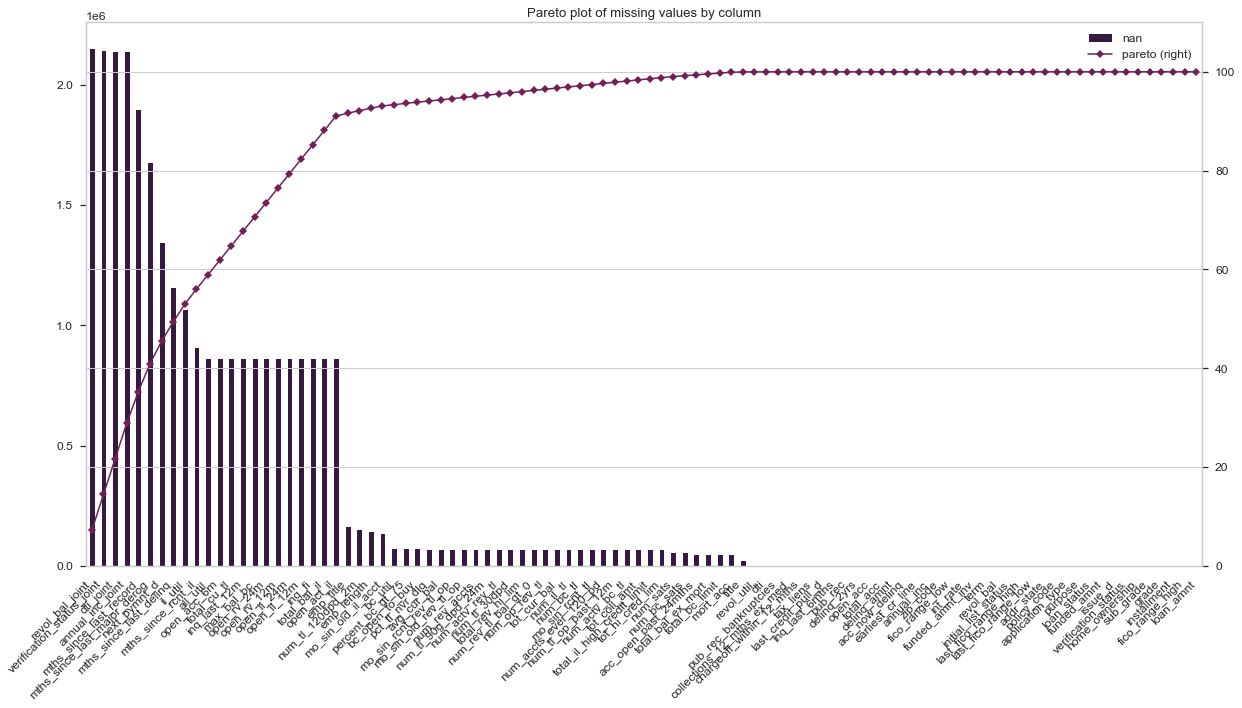

In [ ]:
fig, axes = plt.subplots(figsize=(20, 10))
ax1 = missing_val.plot(use_index=True, y='nan', kind='bar', ax=axes)
ax2 = missing_val.plot(use_index=True, y='pareto', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)
ax2.set_ylim([0, 110])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.xticks(rotation=45)
plt.title("Pareto plot of missing values by column")
plt.show()

To fix the problem of columns with a high degree of missing values, we exclude columns with more than 20 % of missing values. We are aware, that by removing features a bias is introduced. However, it's common practice to remove columns above this threshold, as showed in literature.

In [ ]:
threshold = 0.80

percentage_missing_val = data.isna().sum() / len(data)

percentage_missing_val = percentage_missing_val[percentage_missing_val >= threshold]
threshold_abs = int(threshold * len(data))
data = data.dropna(axis=1, thresh=threshold_abs)

print(percentage_missing_val)

mths_since_last_record       0.841131
annual_inc_joint             0.946605
dti_joint                    0.946607
verification_status_joint    0.948808
revol_bal_joint              0.952218
dtype: float64


As one can see below, the remaining missing values appear in a **completely random (MCAR)** fashion. 

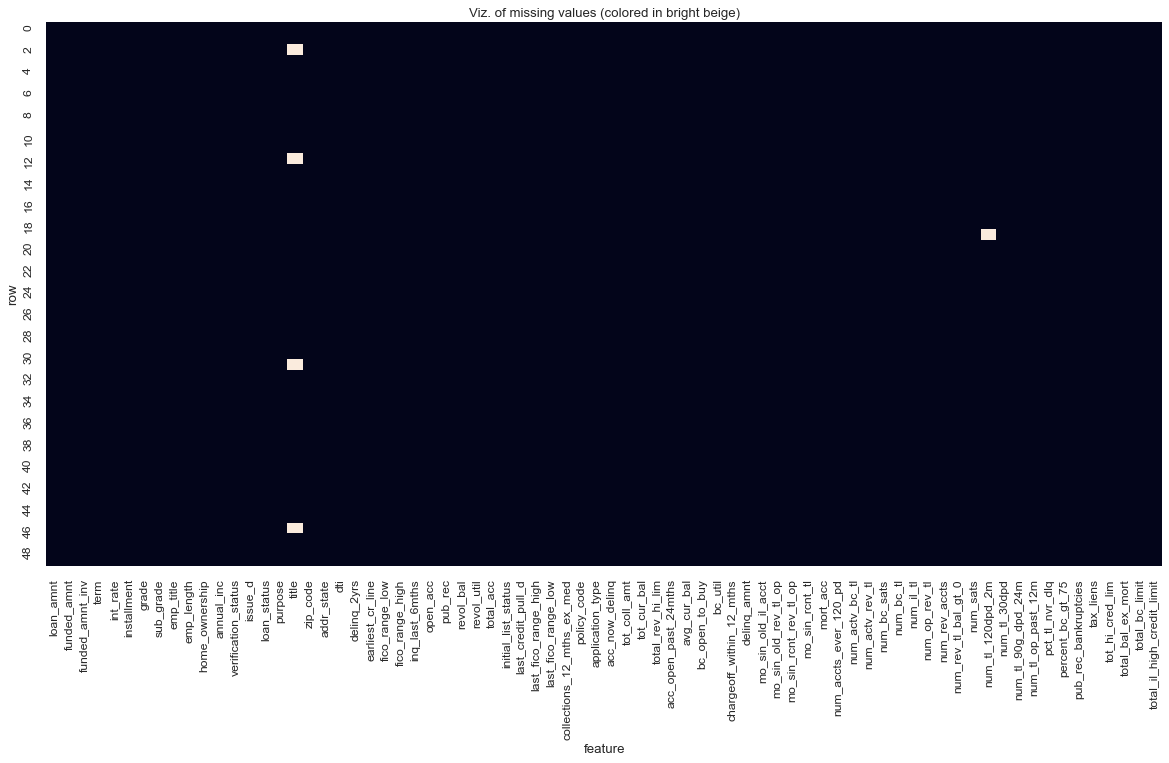

In [ ]:
visualize_nan()


Going back to the data set. There are some rows, where the volume and many other features are null. We exclude these loans without volume from analysis, as every loan must have an amount.



In [ ]:
data = data[data.loan_amnt.notna()]

This leads to the following result, where bright organge indicates the missing data.

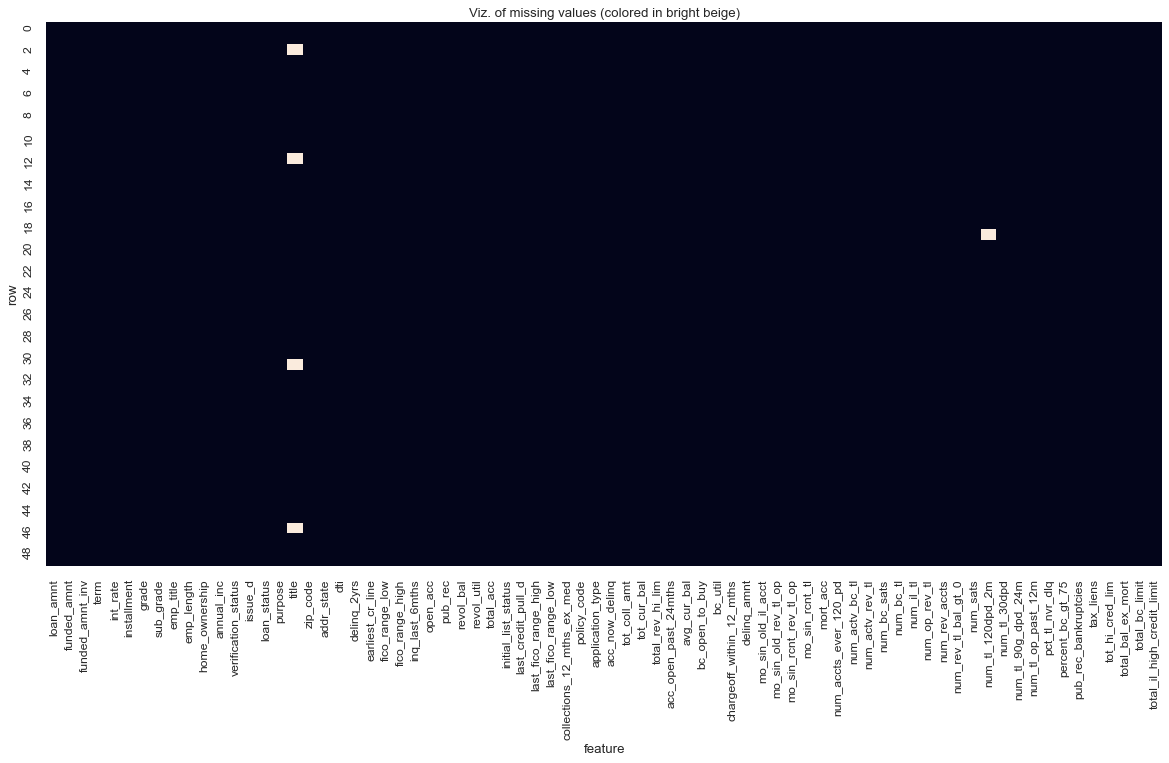

In [ ]:
visualize_nan()

Some of the data columns have no proper datatype for visualization, so we apply some datatypes (e. g. categorical, string and datetime) automatically to make visualization and data processing easier. This can be seen below.

In [ ]:
# convert to categorical
categorical = ['addr_state', 'term', 'application_type', 'initial_list_status', 'loan_status', 'grade', 'sub_grade',
               'home_ownership', 'verification_status', 'purpose', 'emp_length', 'zip_code']
data[categorical] = data[categorical].apply(lambda x: x.astype('category'))

# convert to string
strs = ['emp_title', 'title']
data[strs] = data[strs].apply(lambda x: x.astype('string'))

# convert to datetime
dts = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
data[dts] = data[dts].apply(lambda x: pd.to_datetime(x, format="%b-%Y", errors='coerce'))


print(data.dtypes)

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                category
int_rate                             float64
installment                          float64
grade                               category
sub_grade                           category
emp_title                             string
emp_length                          category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_d                       datetime64[ns]
loan_status                         category
purpose                             category
title                                 string
zip_code                            category
addr_state                          category
dti                                  float64
delinq_2yrs                          float64
earliest_cr_line              datetime64[ns]
fico_range

## Number of unique classes per feature

Next, we investigate how many different classes a feature has. This is done, to e. g. identify constant columns.

In [ ]:
data_classes = []
for row in data.columns.tolist():
    data_classes.append({'column': row, 'count': len(data[row].unique())})
amount = pd.DataFrame(data_classes).sort_values('count')
print(amount)

                        column   count
35                 policy_code       1
36            application_type       2
30         initial_list_status       2
3                         term       2
12         verification_status       3
63                num_tl_30dpd       6
10              home_ownership       6
6                        grade       7
62            num_tl_120dpd_2m       8
14                 loan_status       9
37              acc_now_delinq      10
9                   emp_length      12
45    chargeoff_within_12_mths      12
68        pub_rec_bankruptcies      13
15                     purpose      14
34  collections_12_mths_ex_med      17
24              inq_last_6mths      29
65          num_tl_op_past_12m      34
64          num_tl_90g_dpd_24m      35
7                    sub_grade      35
20                 delinq_2yrs      38
69                   tax_liens      43
53              num_actv_bc_tl      43
26                     pub_rec      44
52       num_accts_ever_1

**Observations**:

- The features `purpose` and `title` contain similar content. Since `purpose` only contains 14 classes and `title` contains more than 60,000 classes we keep `purpose` and drop `title`.

- More over we drop `emp_title`, as it contains either free-text or a high number of unique values, which is true for the later. We expect little loss in information by deleting these variables.

- As `policy_code` is constant, it can be also dropped.

In [ ]:
data = data.drop(columns=['emp_title', 'title', 'policy_code'])

Next, we analyse categorical features by looking at their $k$ most frequent values.

In [ ]:
k = 10
data['term'].value_counts().head(k)

 36 months    1609754
 60 months     650914
Name: term, dtype: int64

In [ ]:
data['addr_state'].value_counts().head(k)

CA    314533
NY    186389
TX    186335
FL    161991
IL     91173
NJ     83132
PA     76939
OH     75132
GA     74196
VA     62954
Name: addr_state, dtype: int64

In [ ]:
data['application_type'].value_counts().head(k)

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

In [ ]:
data['initial_list_status'].value_counts().head(k)

w    1535467
f     725201
Name: initial_list_status, dtype: int64

In [ ]:
data['loan_status'].value_counts().head(k)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [ ]:
data['grade'].value_counts().head(k)

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [ ]:
data['sub_grade'].value_counts().head(k)

C1    145903
B5    140288
B4    139793
B3    131514
C2    131116
C3    129193
C4    127115
B2    126621
B1    125341
C5    116726
Name: sub_grade, dtype: int64

In [ ]:
data['home_ownership'].value_counts().head(k)

MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64

In [ ]:
data['verification_status'].value_counts().head(k)

Source Verified    886231
Not Verified       744806
Verified           629631
Name: verification_status, dtype: int64

In [ ]:
data['purpose'].value_counts().head(k)

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
Name: purpose, dtype: int64

In [ ]:
data['emp_length'].value_counts().head(k)

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
Name: emp_length, dtype: int64

## Analyze loan status

After doing all this preprocessing we put our focus on 'loan_status'. In a first step the different loan status categories and their quantities are identified to categorize them in "default" and "non-default"

In [ ]:
data['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

<AxesSubplot:xlabel='loan_status'>

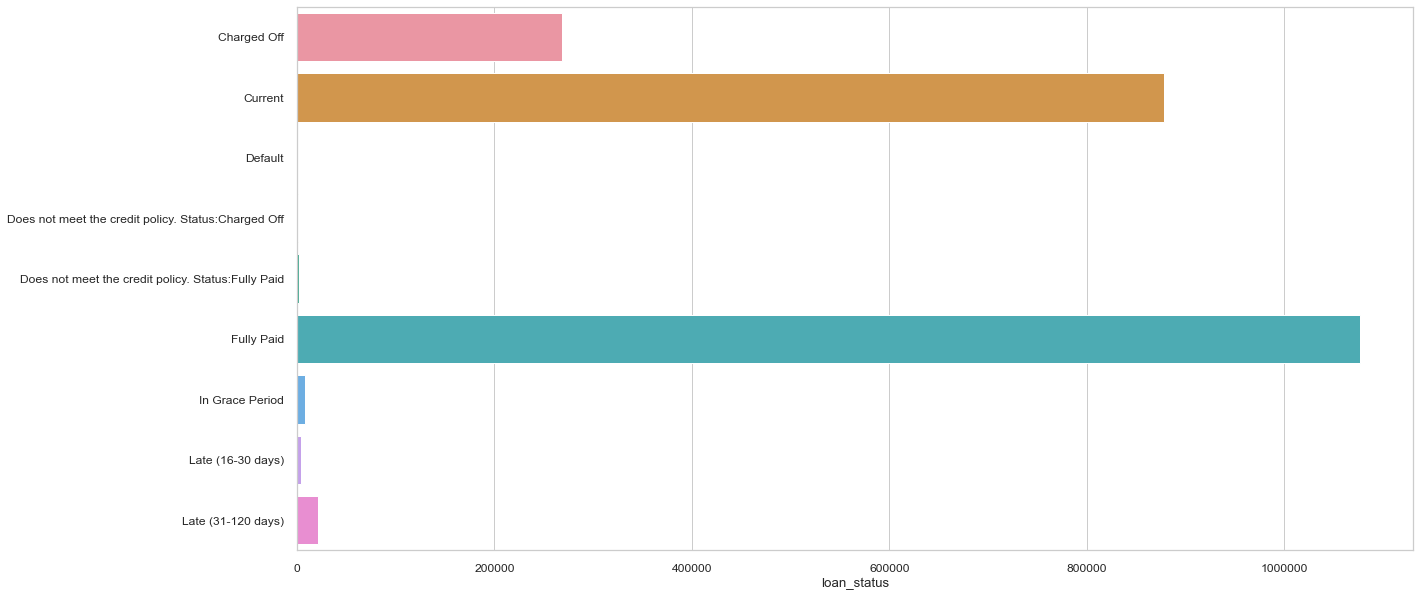

In [ ]:
loan_status_absolute = data['loan_status'].value_counts()
loan_status_absolute = loan_status_absolute.to_frame()

fig, ax = plt.subplots(figsize=(20, 10))
plt.ticklabel_format(style='plain')
sns.barplot(x='loan_status', y=loan_status_absolute.index, data=loan_status_absolute, ax=ax)

Next, we group `loan_status` to be either default or non-default to allow for binary classification. We save the result as `TARGET`.

We apply the same grouping as *Vinod Kumar, Natajan et. al* in the paper *Credit Risk Analysis in Peer-to-Peer Lending System*.

In [ ]:
default_categories = ['Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']
data['TARGET'] = data['loan_status'].isin(default_categories)

data['TARGET'].value_counts()

False    1965492
True      295176
Name: TARGET, dtype: int64

One can see from the above print, that the vast majority of loans is non default and hereby the majority class. This is expected, as most of the loans actually get repaid.

In the plot below, we also visualized how the `loan_status` contributes to the `TARGET`.

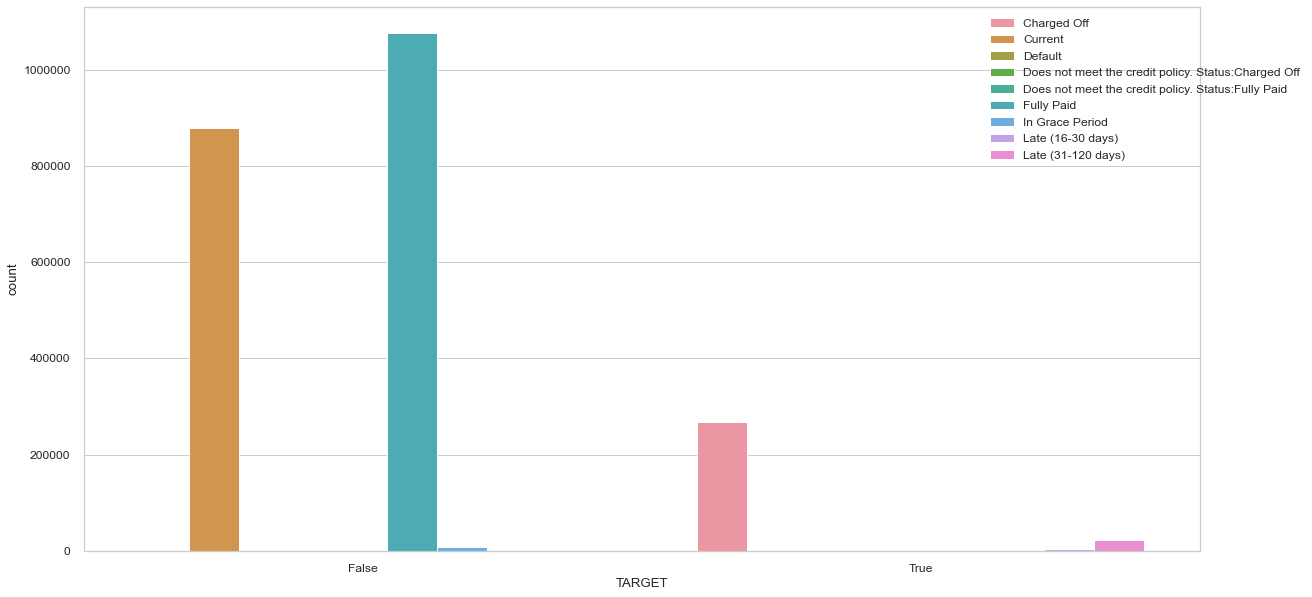

In [ ]:
_, ax = plt.subplots(figsize=(20, 10))
plt.ticklabel_format(style='plain')
g = sns.countplot(x='TARGET', hue='loan_status', data=data)
g.legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1)
plt.show();

## default status by debt-to-income-ratio

For calculation of debt-to-income-ratio see [here.](https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income)

In the plot below, we compare, how the debt-to-income ratio stays in relation to the default status. One can see no clear trend e. g. that a significantly higher debt-to-income ratio leads to more defaults. One has acknowledge though, that for some debt-to-income ratios there are fewer observations than for others. Thus, there might be more variation. 

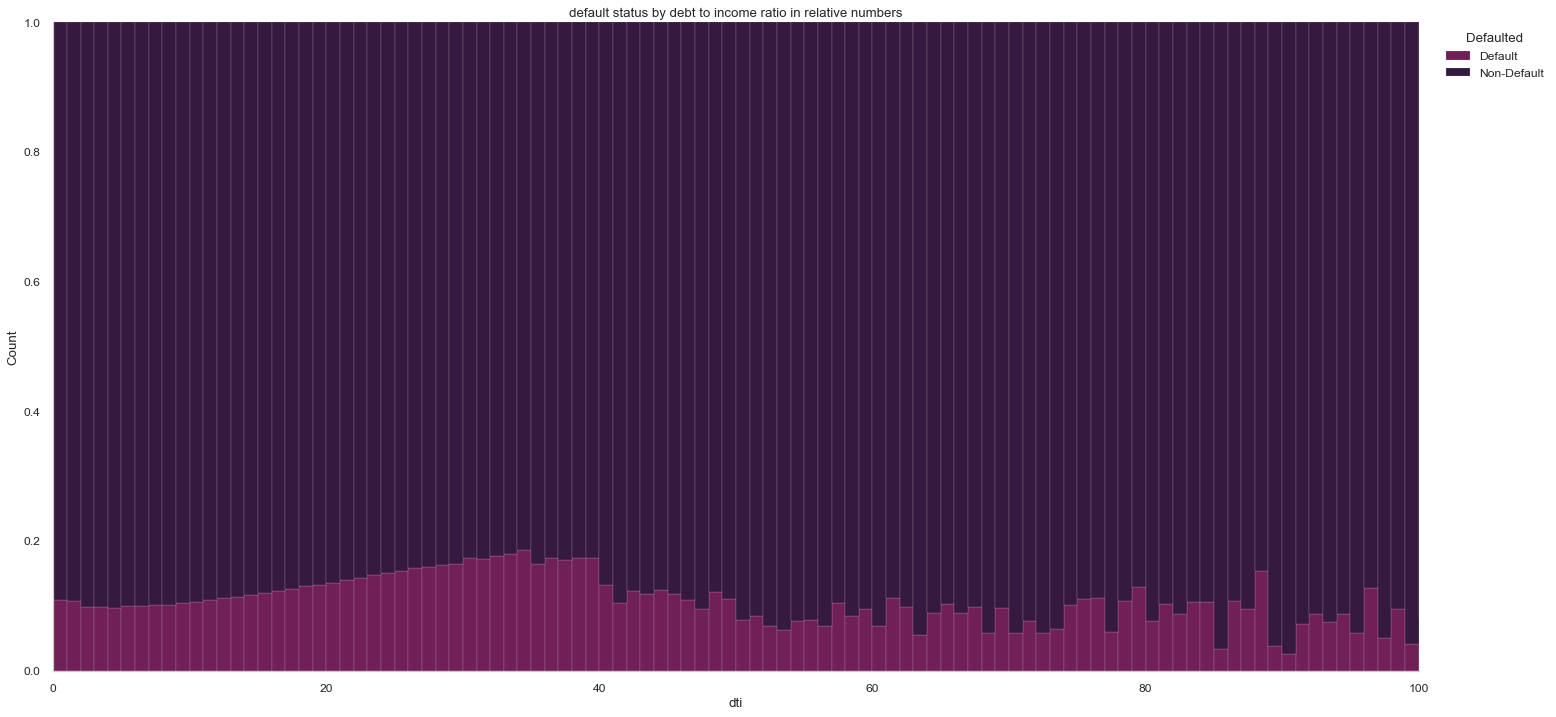

In [ ]:
g = sns.displot(data, x='dti', hue='TARGET', multiple='fill', legend=False, height=10, aspect=20 / 10, alpha=1,
                bins=1000)
plt.title("default status by debt to income ratio in relative numbers")
plt.xlim(0, 100)
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.1, 1))
plt.show(g);

## default status by term structure and amount

Next, we look at the term structure, amount and default status.

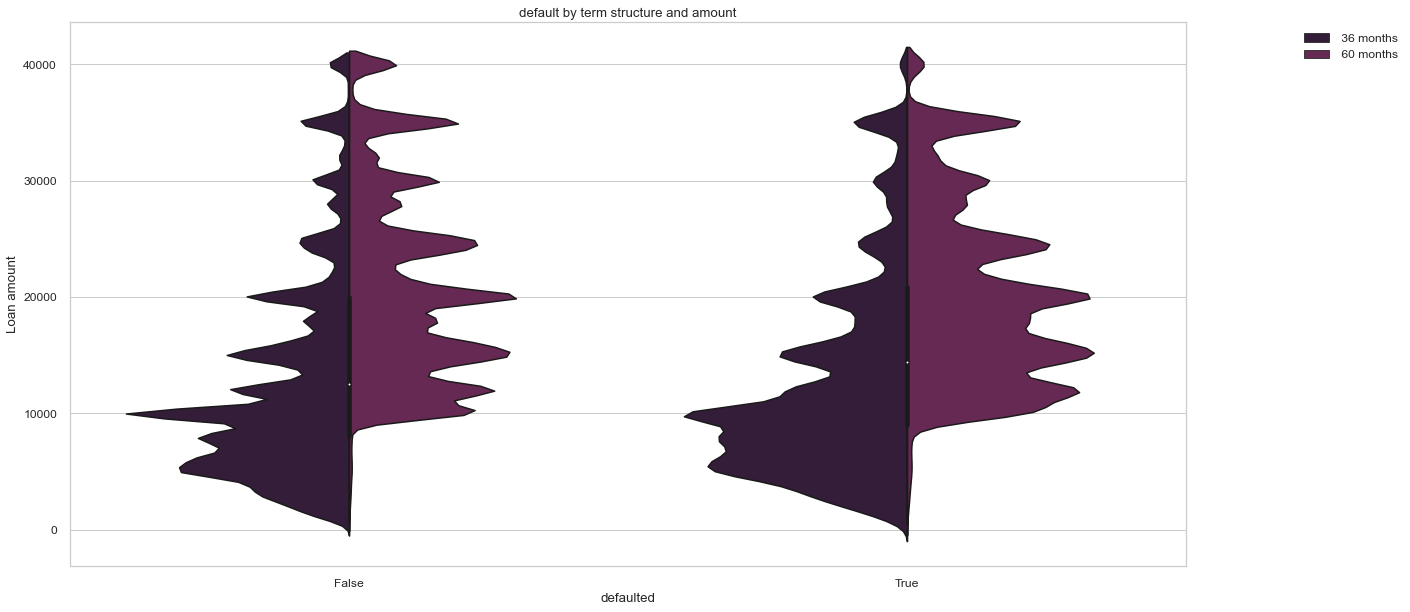

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x="TARGET", y="loan_amnt", data=data, hue="term", split=True)
plt.title("default by term structure and amount")
plt.xlabel("defaulted")
plt.ylabel("Loan amount")
plt.legend(bbox_to_anchor=(1.2, 1));

## default status by grade

In the following paragraph we investigate the default status by grade. One would expect, that a poor grade, leads also to a higher probability of default. We investigate this hypothesis by looking at the absolute numbers first and then at the relative numbers.

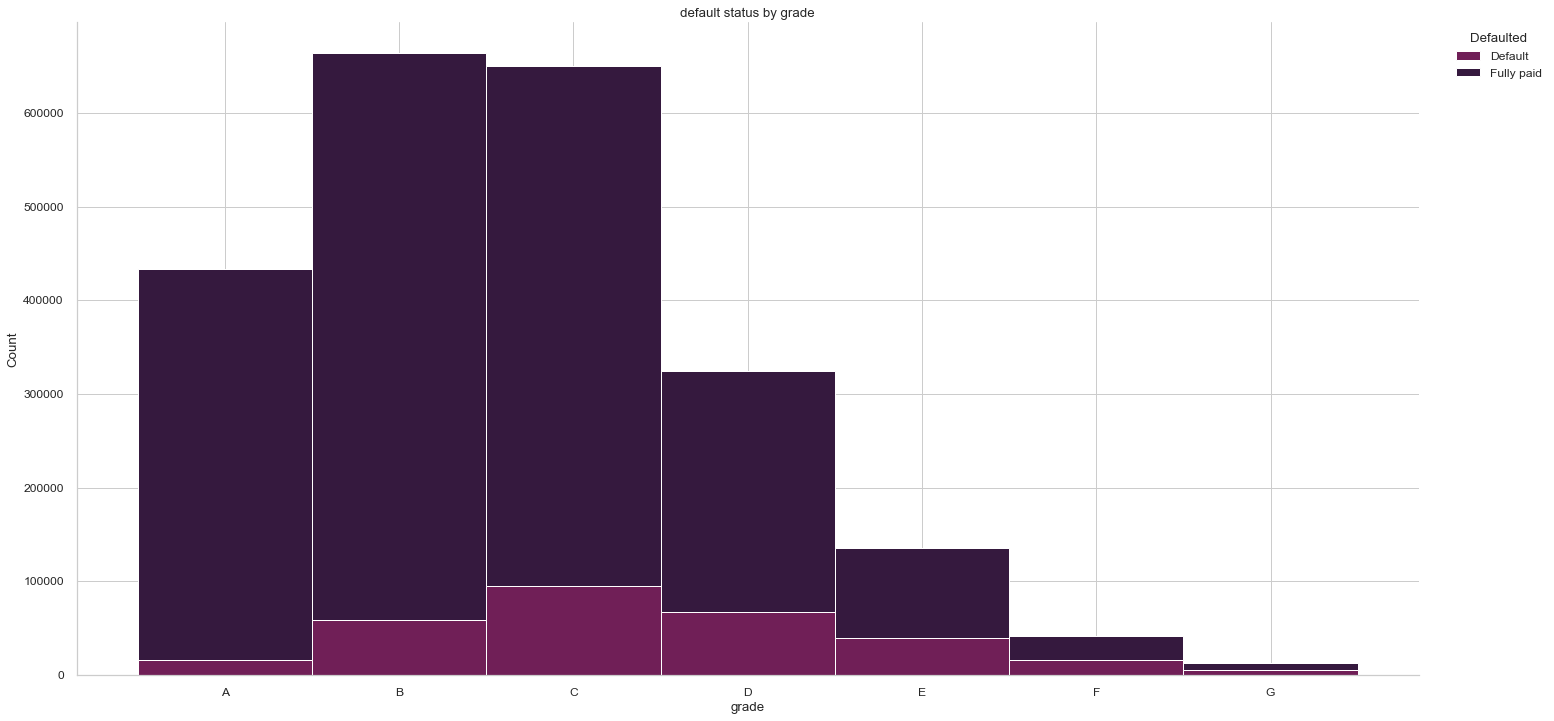

In [ ]:
g = sns.displot(data, x='grade', hue='TARGET', multiple='stack', legend=False, height=10, aspect=20 / 10, alpha=1);
plt.title("default status by grade")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Fully paid'], bbox_to_anchor=(1.1, 1))
plt.show(g);

Looking at the relative numbers, one can clearly say, the worse the rating, the higher the probability of default is. This is consistent with what is found in papers on the data set.

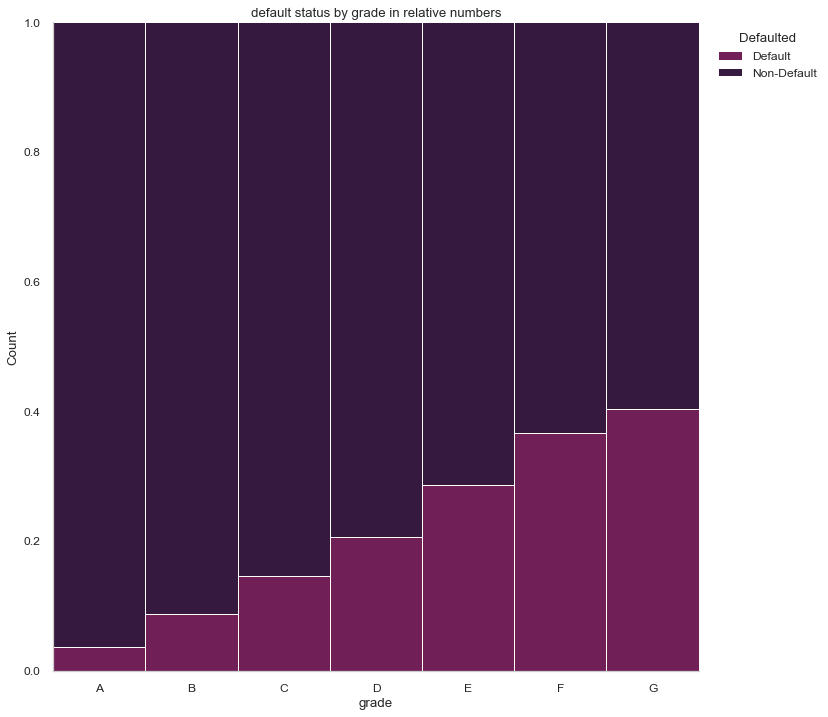

In [ ]:
g = sns.displot(data, x='grade', hue='TARGET', multiple='fill', legend=False, height=10, aspect=1, alpha=1)
plt.title("default status by grade in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.2, 1))
plt.show(g);

## default status by grade and interest rate

We continue our analysis by comparing the grade and interest rate of default and non-default loans.

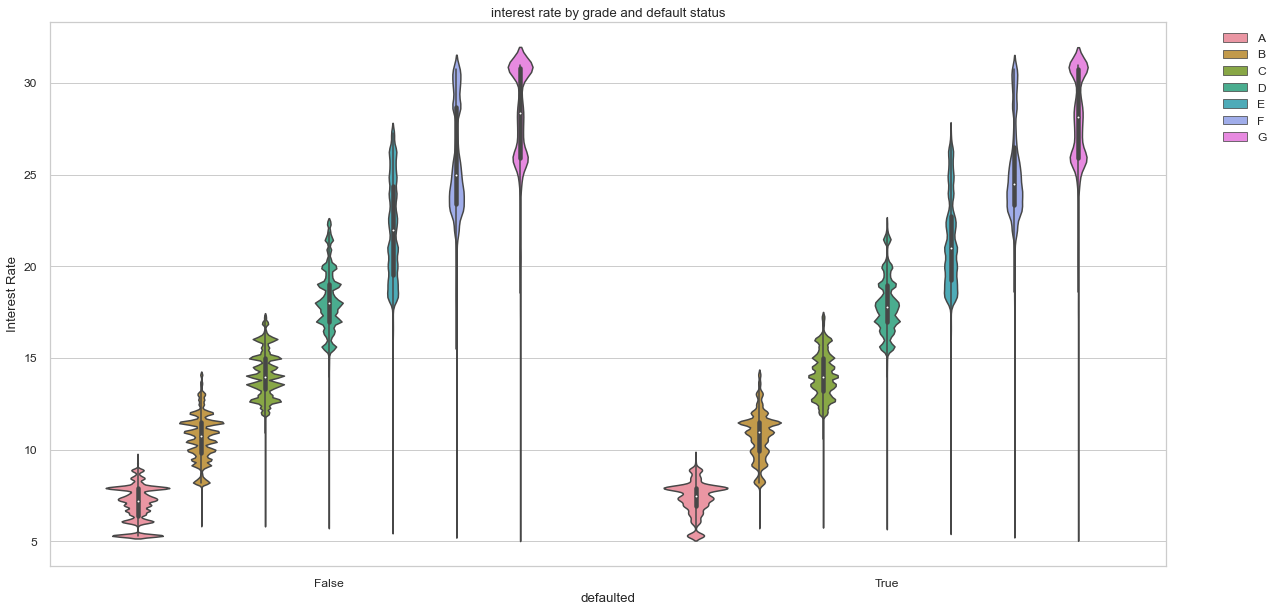

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x="TARGET", y="int_rate", data=data, hue="grade")
plt.legend(bbox_to_anchor=(1.1, 1))
plt.title("interest rate by grade and default status")
plt.xlabel("defaulted")
plt.ylabel("Interest Rate");

# Default status by application type

We drill down further by looking at the loan amount and the application type and how both correspond to the default status.

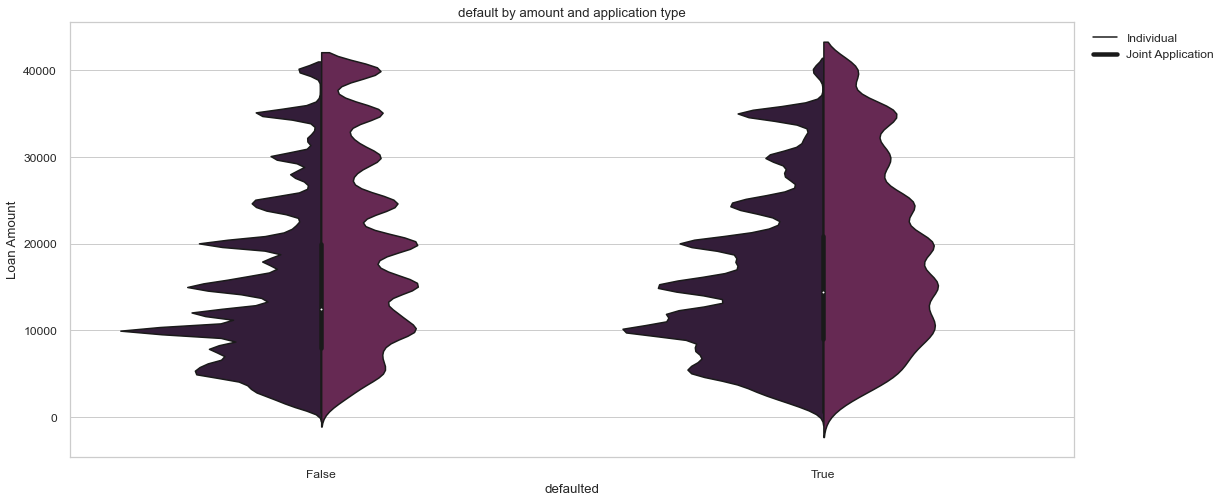

In [ ]:
fig = plt.figure(figsize=(18, 8))
sns.violinplot(x="TARGET", y="loan_amnt", data=data, hue="application_type", split=True)
plt.title("default by amount and application type")
plt.xlabel("defaulted")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=1, labels=['Individual', 'Joint Application']);
plt.ylabel("Loan Amount");

## Default status by working experience

Interestingly the data set contains also information on the working working experience of the applicants. 

However, as it can bee seen in the plot below, long(er) working experience is no saver from defaulted loans.

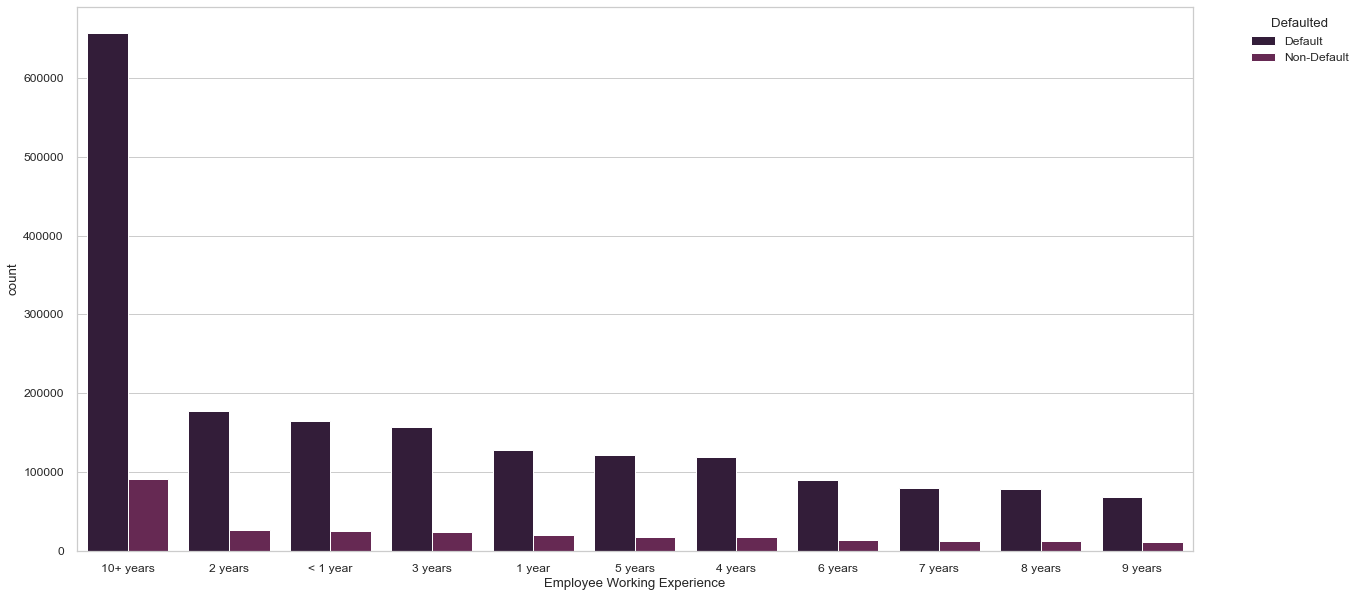

In [ ]:
fig = plt.figure(figsize=(20, 10))

sns.countplot(x='emp_length', hue='TARGET', data=data, order=data['emp_length'].value_counts().index)
plt.xlabel('Employee Working Experience')
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.15, 1))
plt.show()

## Default status by state

Next, we look at the default state of loans from different US states both in absolute and relative numbers.

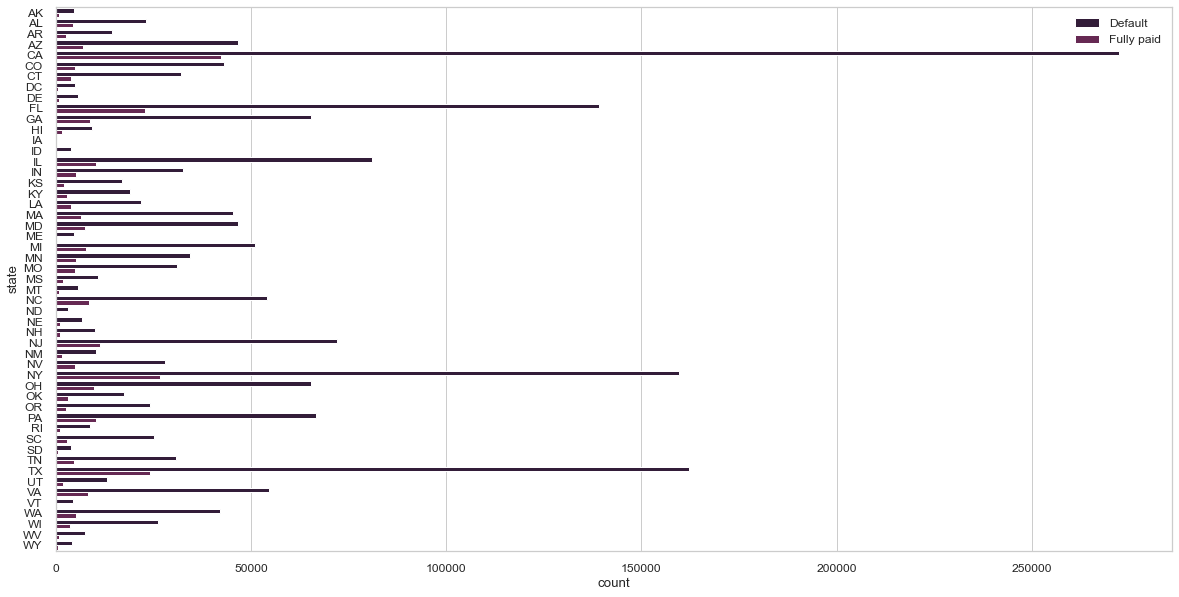

In [ ]:
_, ax = plt.subplots(figsize=(20, 10))
plt.ticklabel_format(style='plain')
g = sns.countplot(y='addr_state', hue='TARGET', data=data, ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, labels=['Default', 'Fully paid'])
plt.ylabel("state")
plt.xlabel("count")
plt.show(g);

One can see that there is a greater relative no. of defaulted loans in `IA` and relatively few in `ID`. One should acknowledge that these states are also among the states with the fewest loans in total. So the data basis is thin. 

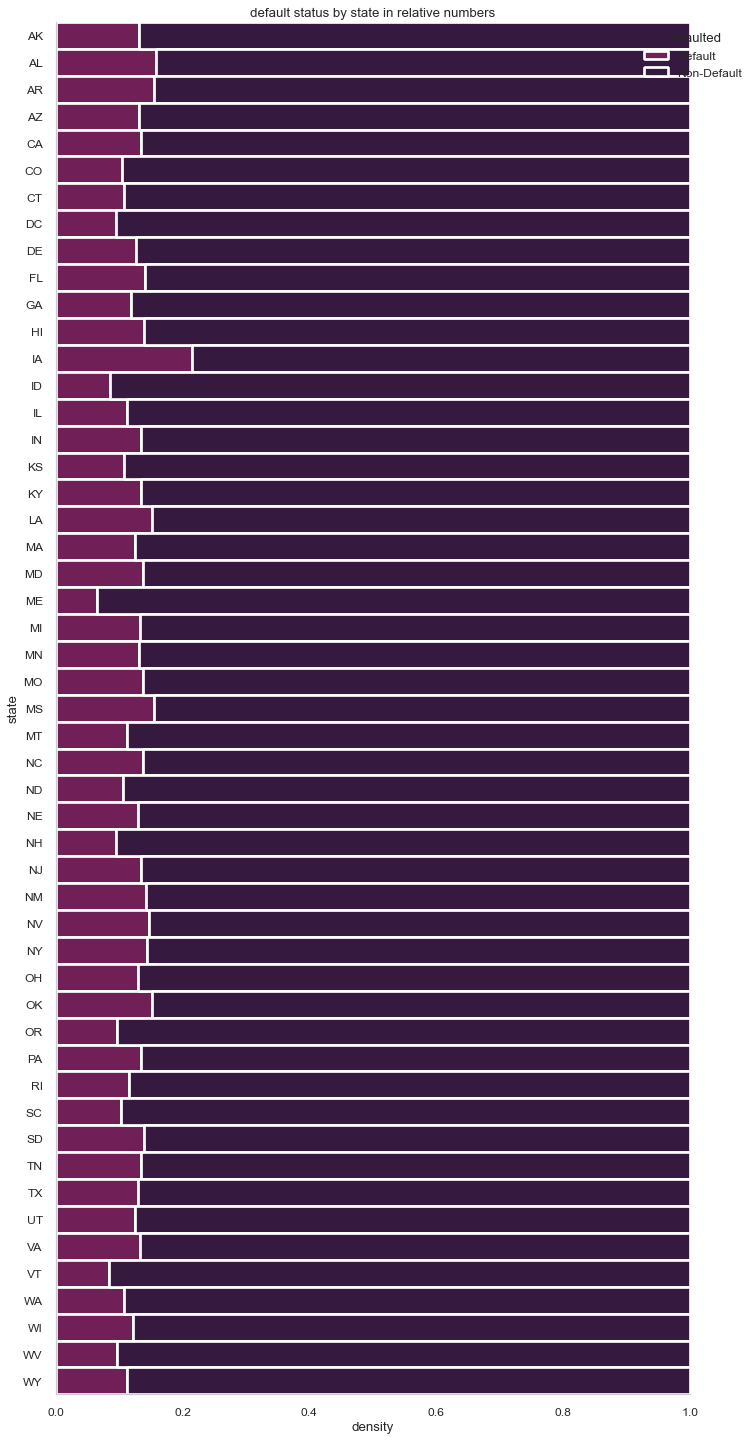

In [ ]:
g = sns.displot(data, y='addr_state', hue='TARGET', multiple='fill', legend=False, height=20, aspect=10 / 20, alpha=1)
plt.title("default status by state in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.1, 1))
plt.ylabel("state")
plt.xlabel("density")
plt.show(g);

## default status by purpose

Next, we look at the default status by purpose.

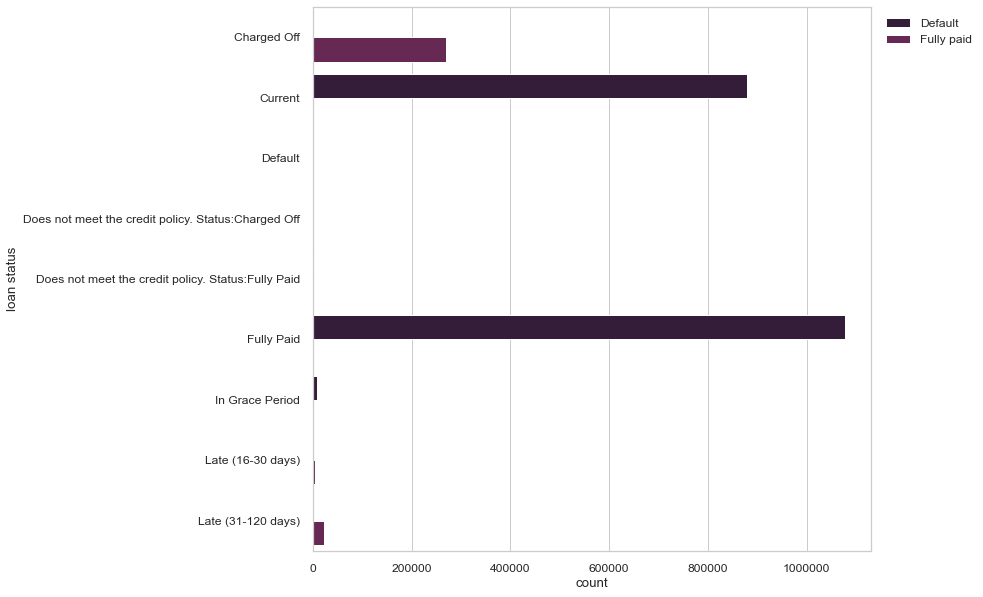

In [ ]:
_, ax = plt.subplots(figsize=(10, 10))
plt.ticklabel_format(style='plain')
g = sns.countplot(y='loan_status', hue='TARGET', data=data, ax=ax)
g.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, labels=['Default', 'Fully paid'])
plt.ylabel("loan status")
plt.show();

## Interest rate by grade

Next, we continue with the interest rate and look how the interest rate relates to the grade.

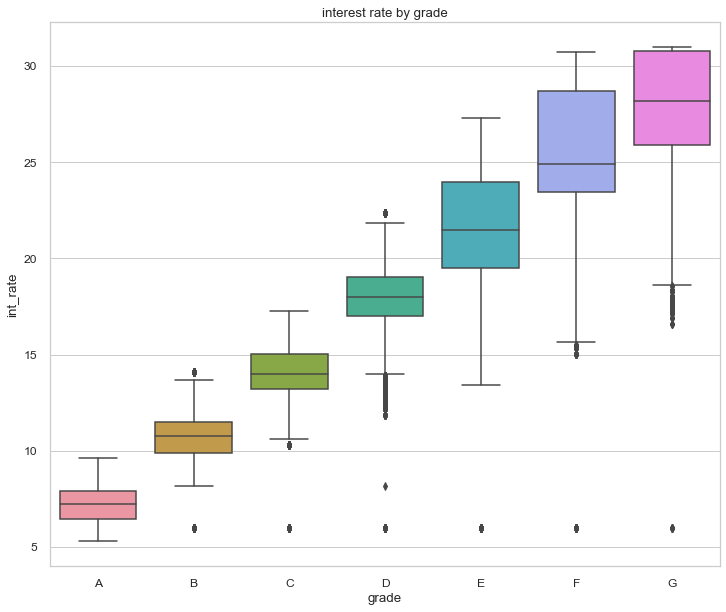

In [ ]:
plt.figure(figsize=(12, 10))
g = sns.boxplot(data=data, x='grade', y='int_rate')
plt.title("interest rate by grade")
plt.show(g);

## default status by interest rate

To enhance our analysis, we also investigate how the default status is for different interest rates both in absolute and in the next-but-one plot in relative numbers.

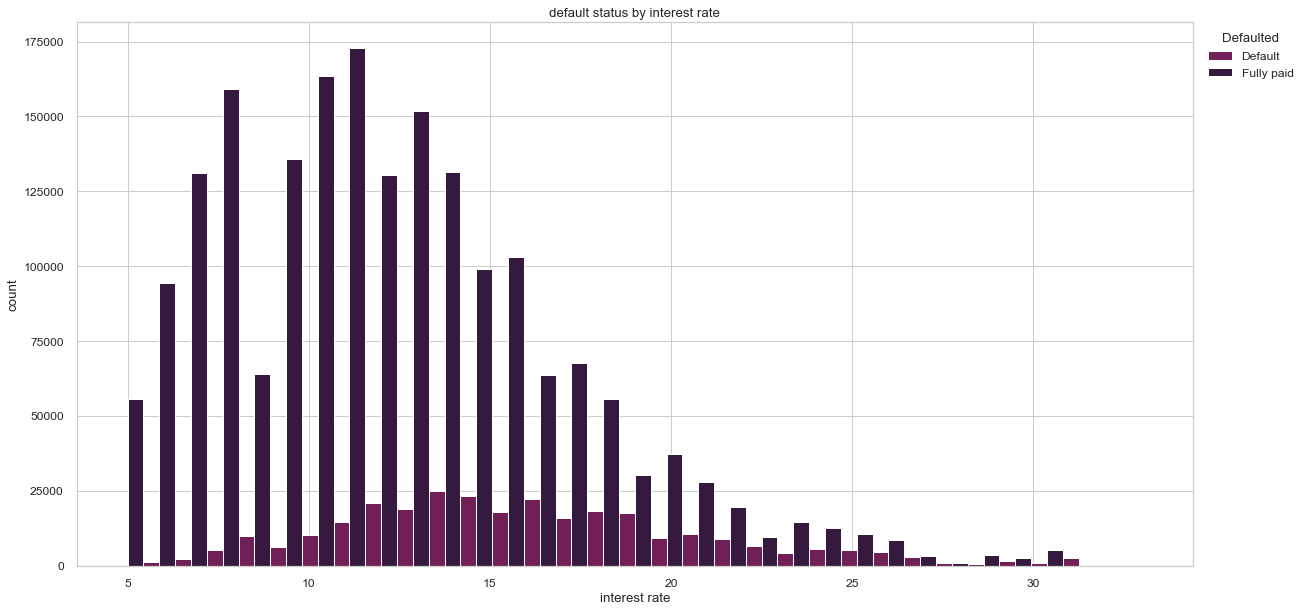

In [ ]:
plt.figure(figsize=(20, 10))
bins = np.linspace(5, 33, 33)
g = sns.histplot(data, x='int_rate', hue='TARGET', multiple='dodge', legend=False, alpha=1, bins=bins);
plt.title("default status by interest rate")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Fully paid'], bbox_to_anchor=(1.1, 1))
plt.xlabel("interest rate")
plt.ylabel("count")
plt.show(g);

As one can see from the plot below, the higher the interest rate, the higher the chance of default. One has to acknowledge though, that some bins (esspecially on the far right) only few observations are present. This leads to those spikes.

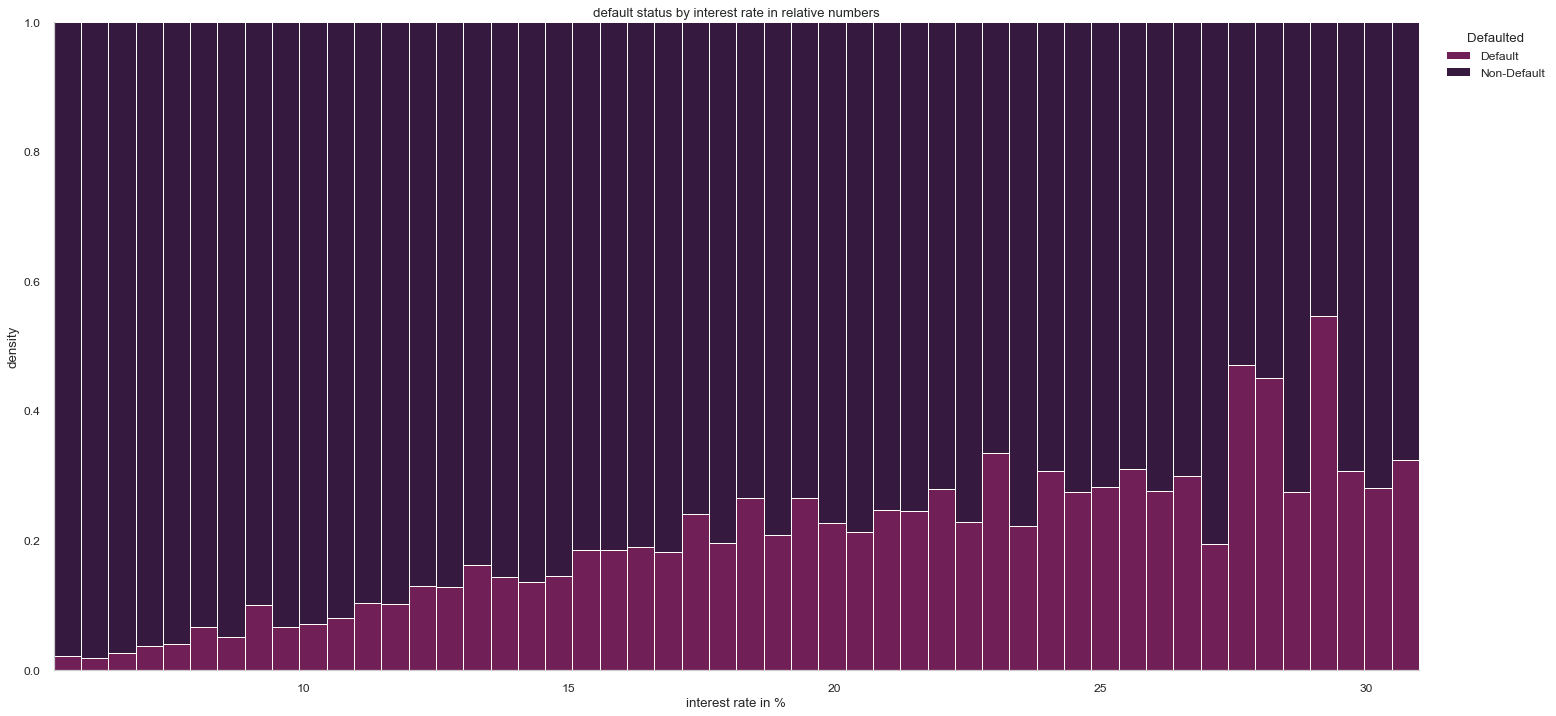

In [ ]:
g = sns.displot(data, x='int_rate', hue='TARGET', multiple='fill', legend=False, height=10, bins=50, aspect=20 / 10,
                alpha=1)
plt.title("default status by interest rate in relative numbers")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'], bbox_to_anchor=(1.1, 1))
plt.xlabel("interest rate in %")
plt.ylabel("density")
plt.show();

## Analyze income

We do some further investigations on the income. It's important to us, to compare the income to the average state income, as income is often higher in metropolitan areas, where also the expenses for living are higher. We use thrid party information to advance our analysis.

In [ ]:
income_by_states = income_by_states[['NAME', 'S1901_C01_013E']]
income_by_states.rename(columns={'NAME': 'state', 'S1901_C01_013E': 'income'}, inplace=True)

income_by_states.head(60)

state                                       income
0   Geographic Area Name  Estimate!!Households!!Mean income (dollars)
1                Alabama                                        69091
2                 Alaska                                        96080
3                Arizona                                        80477
4               Arkansas                                        66766
5             California                                       107384
6               Colorado                                        96218
7            Connecticut                                       111303
8               Delaware                                        84896
9                Florida                                        79968
10               Georgia                                        82489
11                Hawaii                                       103162
12                 Idaho                                        73369
13              Illinois                                        91424
14               Indiana                                        73733
15                  Iowa                                        77173
16                Kansas                                        78972
17              Kentucky                                        69724
18             Louisiana                                        69225
19                 Maine                                        73935
20              Maryland                                       109774
21         Massachusetts                                       110501
22              Michigan                                        77682
23             Minnesota                                        93047
24           Mississippi                                        61944
25              Missouri                                        75013
26               Montana                                        72648
27              Nebraska                                        78793
28                Nevada                                        81039
29         New Hampshire                                        97994
30            New Jersey                                       114853
31            New Mexico                                        66752
32              New York                                       100422
33        North Carolina                                        76693
34          North Dakota                                        82435
35                  Ohio                                        76151
36              Oklahoma                                        71632
37                Oregon                                        85235
38          Pennsylvania                                        83765
39          Rhode Island                                        86601
40        South Carolina                                        72742
41          South Dakota                                        74046
42             Tennessee                                        73456
43                 Texas                                        85780
44                  Utah                                        91096
45               Vermont                                        79514
46              Virginia                                       100884
47            Washington                                        99762
48         West Virginia                                        61707
49             Wisconsin                                        79656
50               Wyoming                                        81935
51           Puerto Rico                                        32044

In [ ]:
state_map = pd.read_csv("./data/states_mapping.csv", sep=';')
state_map.head(50)

iso_code                      subdivision_name
0        AL                               Alabama
1        AK                                Alaska
2        AS                        American Samoa
3        AZ                               Arizona
4        AR                              Arkansas
5        CA                            California
6        CO                              Colorado
7        CT                           Connecticut
8        DE                              Delaware
9        DC                  District of Columbia
10       FL                               Florida
11       GA                               Georgia
12       GU                                  Guam
13       HI                                Hawaii
14       ID                                 Idaho
15       IL                              Illinois
16       IN                               Indiana
17       IA                                  Iowa
18       KS                                Kansas
19       KY                              Kentucky
20       LA                             Louisiana
21       ME                                 Maine
22       MD                              Maryland
23       MA                         Massachusetts
24       MI                              Michigan
25       MN                             Minnesota
26       MS                           Mississippi
27       MO                              Missouri
28       MT                               Montana
29       NE                              Nebraska
30       NV                                Nevada
31       NH                         New Hampshire
32       NJ                            New Jersey
33       NM                            New Mexico
34       NY                              New York
35       NC                        North Carolina
36       ND                          North Dakota
37       MP              Northern Mariana Islands
38       OH                                  Ohio
39       OK                              Oklahoma
40       OR                                Oregon
41       PA                          Pennsylvania
42       PR                           Puerto Rico
43       RI                          Rhode Island
44       SC                        South Carolina
45       SD                          South Dakota
46       TN                             Tennessee
47       TX                                 Texas
48       UM  United States Minor Outlying Islands
49       UT                                  Utah

In [ ]:
# remove comments from df
income_by_states.drop(income_by_states.index[[0]], inplace=True)

# add iso codes and make sub selection
income_by_states = income_by_states.merge(state_map, how='left', left_on='state', right_on='subdivision_name')
income_by_states = income_by_states[['iso_code', 'income']]

income_by_states.head(60)

iso_code  income
0        AL   69091
1        AK   96080
2        AZ   80477
3        AR   66766
4        CA  107384
5        CO   96218
6        CT  111303
7        DE   84896
8        FL   79968
9        GA   82489
10       HI  103162
11       ID   73369
12       IL   91424
13       IN   73733
14       IA   77173
15       KS   78972
16       KY   69724
17       LA   69225
18       ME   73935
19       MD  109774
20       MA  110501
21       MI   77682
22       MN   93047
23       MS   61944
24       MO   75013
25       MT   72648
26       NE   78793
27       NV   81039
28       NH   97994
29       NJ  114853
30       NM   66752
31       NY  100422
32       NC   76693
33       ND   82435
34       OH   76151
35       OK   71632
36       OR   85235
37       PA   83765
38       RI   86601
39       SC   72742
40       SD   74046
41       TN   73456
42       TX   85780
43       UT   91096
44       VT   79514
45       VA  100884
46       WA   99762
47       WV   61707
48       WI   79656
49       WY   81935
50       PR   32044

In [ ]:
lut_income = dict(income_by_states.values)
data["addr_state_avg_income"] = data["addr_state"].replace(lut_income)
data["addr_state_avg_income"] = data["addr_state_avg_income"].apply(lambda x: pd.to_numeric(x, errors="coerce"))
data["state_income_ratio"] = data["annual_inc"] / data["addr_state_avg_income"]
data.head().T

0                    1  \
loan_amnt                                3600.0              24700.0   
funded_amnt                              3600.0              24700.0   
funded_amnt_inv                          3600.0              24700.0   
term                                  36 months            36 months   
int_rate                                  13.99                11.99   
installment                              123.03               820.28   
grade                                         C                    C   
sub_grade                                    C4                   C1   
emp_length                            10+ years            10+ years   
home_ownership                         MORTGAGE             MORTGAGE   
annual_inc                              55000.0              65000.0   
verification_status                Not Verified         Not Verified   
issue_d                     2015-12-01 00:00:00  2015-12-01 00:00:00   
loan_status                          Fully Paid           Fully Paid   
purpose                      debt_consolidation       small_business   
zip_code                                  190xx                577xx   
addr_state                                   PA                   SD   
dti                                        5.91                16.06   
delinq_2yrs                                 0.0                  1.0   
earliest_cr_line            2003-08-01 00:00:00  1999-12-01 00:00:00   
fico_range_low                            675.0                715.0   
fico_range_high                           679.0                719.0   
inq_last_6mths                              1.0                  4.0   
open_acc                                    7.0                 22.0   
pub_rec                                     0.0                  0.0   
revol_bal                                2765.0              21470.0   
revol_util                                 29.7                 19.2   
total_acc                                  13.0                 38.0   
initial_list_status                           w                    w   
last_credit_pull_d          2019-03-01 00:00:00  2019-03-01 00:00:00   
last_fico_range_high                      564.0                699.0   
last_fico_range_low                       560.0                695.0   
collections_12_mths_ex_med                  0.0                  0.0   
application_type                     Individual           Individual   
acc_now_delinq                              0.0                  0.0   
tot_coll_amt                              722.0                  0.0   
tot_cur_bal                            144904.0             204396.0   
total_rev_hi_lim                         9300.0             111800.0   
acc_open_past_24mths                        4.0                  4.0   
avg_cur_bal                             20701.0               9733.0   
bc_open_to_buy                           1506.0              57830.0   
bc_util                                    37.2                 27.1   
chargeoff_within_12_mths                    0.0                  0.0   
delinq_amnt                                 0.0                  0.0   
mo_sin_old_il_acct                        148.0                113.0   
mo_sin_old_rev_tl_op                      128.0                192.0   
mo_sin_rcnt_rev_tl_op                       3.0                  2.0   
mo_sin_rcnt_tl                              3.0                  2.0   
mort_acc                                    1.0                  4.0   
num_accts_ever_120_pd                       2.0                  0.0   
num_actv_bc_tl                              2.0                  5.0   
num_actv_rev_tl                             4.0                  5.0   
num_bc_sats                                 2.0                 13.0   
num_bc_tl                                   5.0                 17.0   
num_il_tl                                   3.0                  6.0   
num_op_rev_tl 

As one can see above, we compare the `annual_inc` with the `addr_state_avg_income` in a new ratio called the `state_income_ratio`.

In the plot below we also plot the distribution of the annual income. 

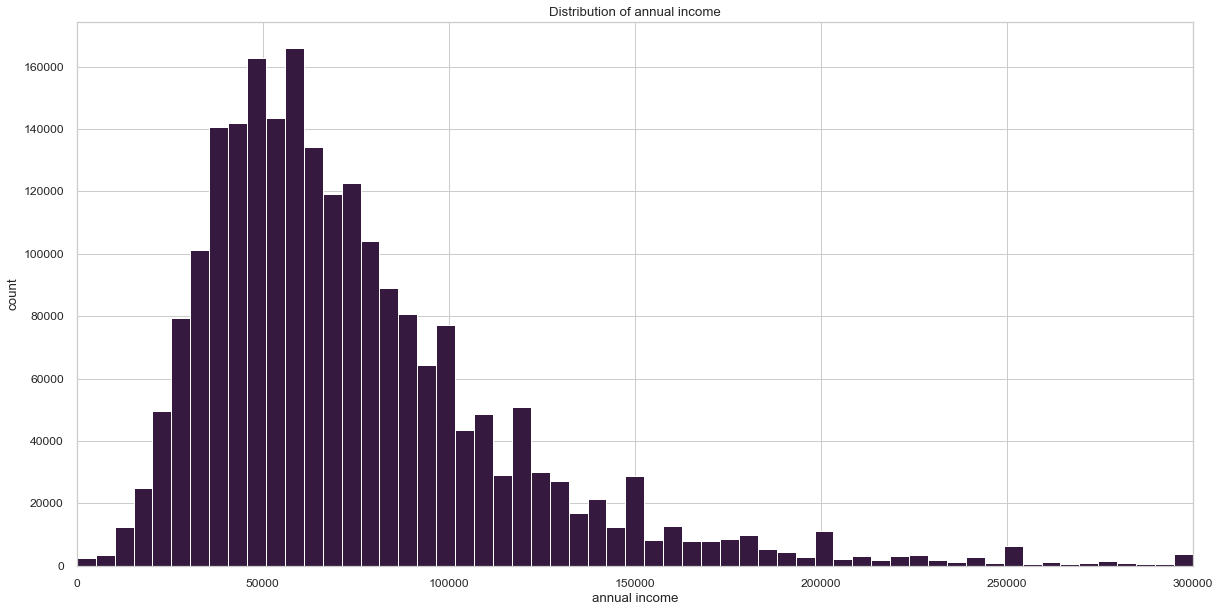

In [ ]:
plt.figure(figsize=(20, 10))
bins = np.linspace(0, 300000, 60)
sns.histplot(data=data, x='annual_inc', bins=bins, kde=False, alpha=1)
plt.title("Distribution of annual income")
plt.xlim(0, 300000)
plt.xlabel("annual income")
plt.ylabel("count")
plt.show()

## Annual Income and Loan Amount of defaulted loans

<Figure size 1440x1440 with 0 Axes>

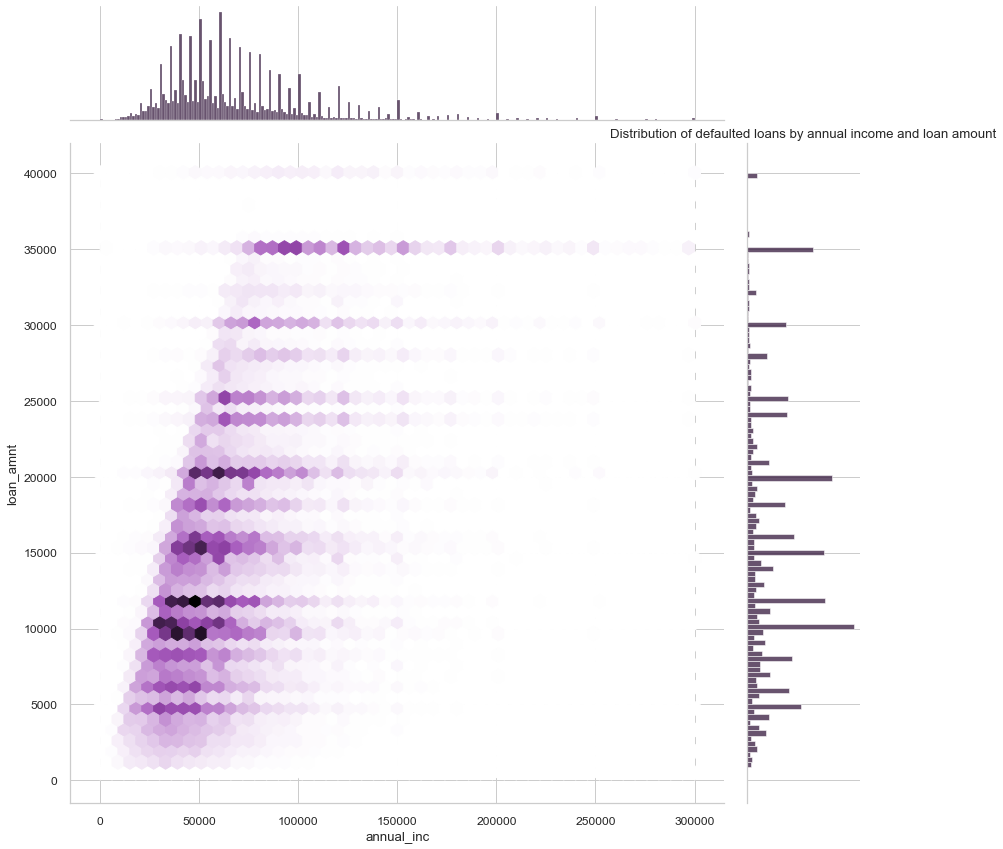

In [ ]:
plt.figure(figsize=(20, 20))
sel_annual_inc_defaulted = data[(data.annual_inc <= 300000) & (data.TARGET == 1)]
sns.jointplot(data=sel_annual_inc_defaulted, x="annual_inc", y="loan_amnt", kind="hex", height=12)
plt.xlabel("annual income")
plt.ylabel("loan amount")
plt.title("Distribution of defaulted loans by annual income and loan amount")
plt.show()

## Analyze effect of joint/ individual application

We end our analyis by looking at the `application_type`. We created plots to check, whether it plays a role, if the loan has been handed out to an individual or to multiple people.

In [ ]:
data['application_type'].value_counts()

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

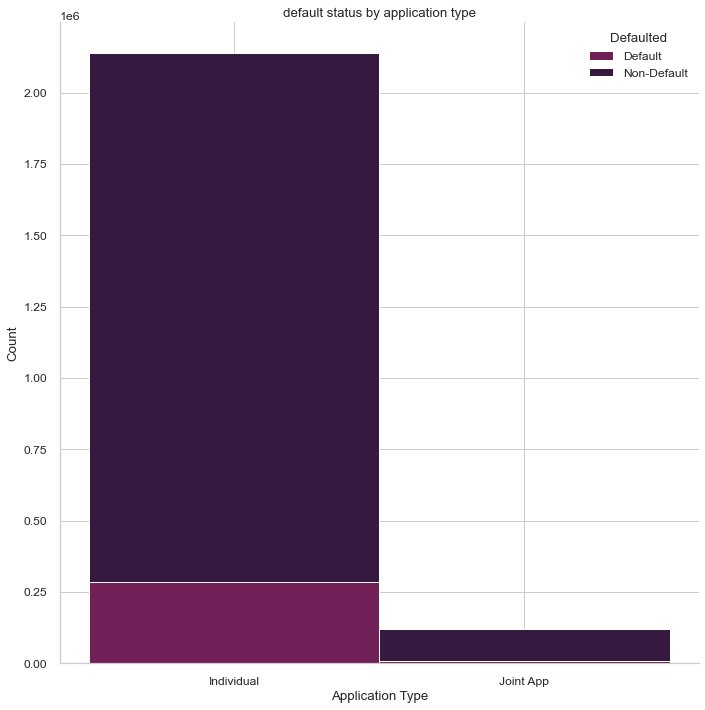

In [ ]:
g = sns.displot(data, x='application_type', hue='TARGET', multiple='stack', legend=False, alpha=1, height=10,
                aspect=10 / 10)
plt.xlabel("Application Type")
plt.title("default status by application type")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'])

## Data Preprocessing

As the amount of missing values, that remain in the dataset, is relatively small, we fill missing values with the modus of each feature.

In [ ]:
data.fillna(data.mode().iloc[0], inplace=True)

This leads to the following results. All NaN's are filled as expected.

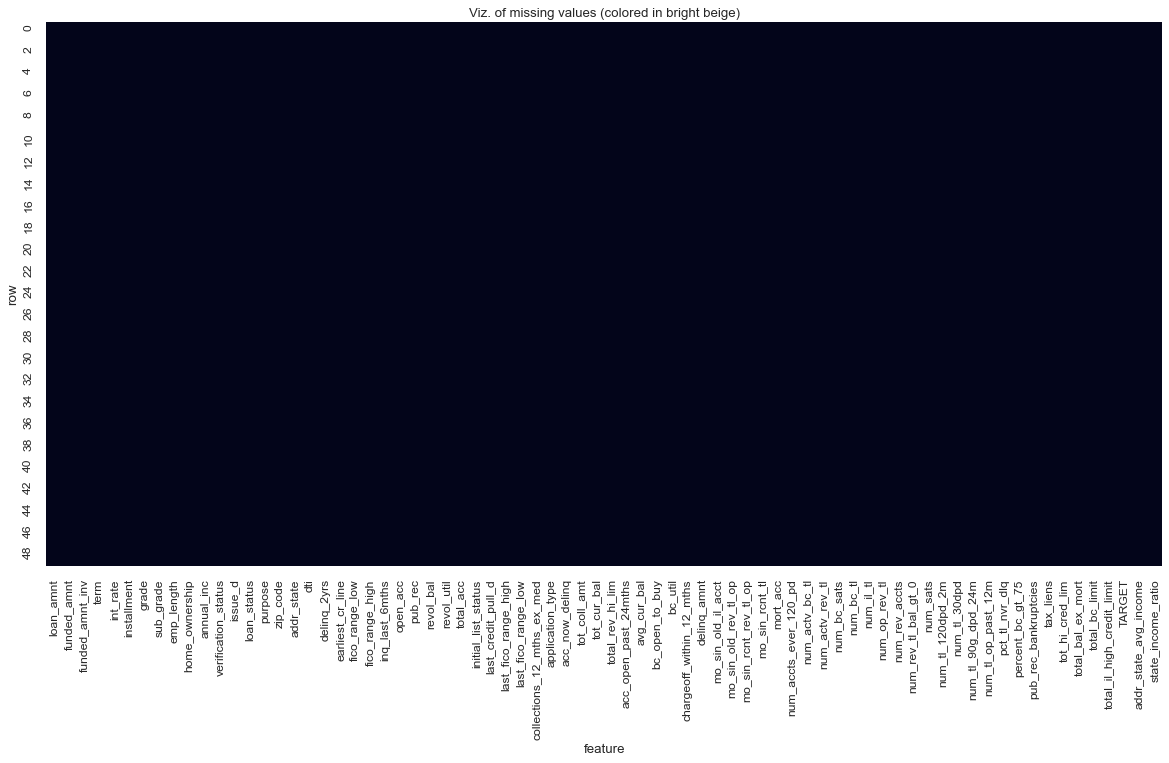

In [ ]:
visualize_nan()

As seen above the dataset contains 2,260,701 entries. This sheer amount of data is hard is hard to process with the tools and processing resources, that we have to our disposal. Therefore, we apply stratified sampling first on the dataset to create a subset with a similar distribution to the original data. The resulting dataset will be 10 % of the original data set.

In [ ]:
# Remove target and loan status from features
features = data.drop(columns=['loan_status', 'TARGET'], axis=1)
# create a 10 % random sub selection
X_stratified, _, y_stratified, _ = train_test_split(features, data.TARGET, test_size=0.90, random_state=42,
                                                    stratify=data.TARGET)

Next, we split the stratified data into two parts. Namely, training data and test data. The training data will be used to train the models and for in-sample testing. Whereas the test data is used for out-of-sample testing. This time we use a 70 % / 30 % split.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_stratified, y_stratified, stratify=y_stratified, test_size=0.3,
                                                    random_state=42)

In [ ]:
print(X_train.dtypes)

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                category
int_rate                             float64
installment                          float64
grade                               category
sub_grade                           category
emp_length                          category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_d                       datetime64[ns]
purpose                             category
zip_code                            category
addr_state                          category
dti                                  float64
delinq_2yrs                          float64
earliest_cr_line              datetime64[ns]
fico_range_low                       float64
fico_range_high                      float64
inq_last_6mths                       float64
open_acc  

Having `datetime64[ns]` dtypes e. g. for `issue_d` is desirable for visualization. However, using these datatypes in our models causes difficulties, as the datetime object have to be converted to some numeric value. We only keep the 'year' and 'month' component.

In [ ]:
# apply to Test and Training set
datetime_columns = data.select_dtypes(include=['datetime64[ns]']).columns

datetime_columns_month = [s + "_mth" for s in datetime_columns]

# extract month from timestamp
X_train[datetime_columns_month] = X_train[datetime_columns].apply(lambda x: x.dt.month)
X_test[datetime_columns_month] = X_test[datetime_columns].apply(lambda x: x.dt.month)

# extract year from timestamp
X_train[datetime_columns] = X_train[datetime_columns].apply(lambda x: x.dt.year)
X_test[datetime_columns] = X_test[datetime_columns].apply(lambda x: x.dt.year)

print(X_train.dtypes)

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                          category
int_rate                       float64
installment                    float64
grade                         category
sub_grade                     category
emp_length                    category
home_ownership                category
annual_inc                     float64
verification_status           category
issue_d                          int64
purpose                       category
zip_code                      category
addr_state                    category
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                 int64
fico_range_low                 float64
fico_range_high                float64
inq_last_6mths                 float64
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util               

C:\Users\Markus\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Next, we also convert the boolean `TARGET` to integers, as it simplifies the work with some of our models. As this was formerly a boolean variable, the impact is minor.

In [ ]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

While variables of type 'Categorical' e. g. `term` are great for visualization, they also require further processing to be used by machine learning models. We apply some Label-encoding. The problem with label encoding is, that an unfortunate ordering can lead to poor results when applying our models.

To address this issue, use a 2 step approach:
- We use label encoding provided by pandas, if the ordering is appropriate.
- Otherwise, we apply some manual ordering.

In order to do so, we first check the order for all categorical variables, to find out which variables require manual ordering.

In [ ]:
cat_columns = X_train.select_dtypes(include=['category']).columns

for cat in cat_columns:
    mapping = dict(enumerate(X_train[cat].cat.categories))
    print(f"{cat}: {mapping}")

term: {0: ' 36 months', 1: ' 60 months'}
grade: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}
sub_grade: {0: 'A1', 1: 'A2', 2: 'A3', 3: 'A4', 4: 'A5', 5: 'B1', 6: 'B2', 7: 'B3', 8: 'B4', 9: 'B5', 10: 'C1', 11: 'C2', 12: 'C3', 13: 'C4', 14: 'C5', 15: 'D1', 16: 'D2', 17: 'D3', 18: 'D4', 19: 'D5', 20: 'E1', 21: 'E2', 22: 'E3', 23: 'E4', 24: 'E5', 25: 'F1', 26: 'F2', 27: 'F3', 28: 'F4', 29: 'F5', 30: 'G1', 31: 'G2', 32: 'G3', 33: 'G4', 34: 'G5'}
emp_length: {0: '1 year', 1: '10+ years', 2: '2 years', 3: '3 years', 4: '4 years', 5: '5 years', 6: '6 years', 7: '7 years', 8: '8 years', 9: '9 years', 10: '< 1 year'}
home_ownership: {0: 'ANY', 1: 'MORTGAGE', 2: 'NONE', 3: 'OTHER', 4: 'OWN', 5: 'RENT'}
verification_status: {0: 'Not Verified', 1: 'Source Verified', 2: 'Verified'}
purpose: {0: 'car', 1: 'credit_card', 2: 'debt_consolidation', 3: 'educational', 4: 'home_improvement', 5: 'house', 6: 'major_purchase', 7: 'medical', 8: 'moving', 9: 'other', 10: 'renewable_energy', 11: 'smal

As it can be seen above, the ordering of `emp_length` should be changed. As `10+ years` is closer in space to `1 year` than e. g. `2 years`. For the remaining features it's appropriate to encode the value with its key.

In [ ]:
# change the mapping during label encoding by using a mapping
emp_length_to_int = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,
                     '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
                     '8 years': 8, '9 years': 9, '10+ years': 10}

# apply to both test and training set
X_train['emp_length'] = X_train['emp_length'].map(emp_length_to_int).astype('int')
X_test['emp_length'] = X_test['emp_length'].map(emp_length_to_int).astype('int')

<ipython-input-344-f382d9be0d82>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['emp_length'] = X_train['emp_length'].map(emp_length_to_int).astype('int')
<ipython-input-344-f382d9be0d82>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['emp_length'] = X_test['emp_length'].map(emp_length_to_int).astype('int')


In [ ]:
# apply label encoding to test and training set
cat_columns = X_train.select_dtypes(include=['category']).columns
X_train[cat_columns] = X_train[cat_columns].apply(lambda x: x.cat.codes)
X_test[cat_columns] = X_test[cat_columns].apply(lambda x: x.cat.codes)

print(X_train.dtypes)

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                             int8
int_rate                      float64
installment                   float64
grade                            int8
sub_grade                        int8
emp_length                      int32
home_ownership                   int8
annual_inc                    float64
verification_status              int8
issue_d                         int64
purpose                          int8
zip_code                        int16
addr_state                       int8
dti                           float64
delinq_2yrs                   float64
earliest_cr_line                int64
fico_range_low                float64
fico_range_high               float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc   

Since the features have different units, Scaling of the numeric features is necessary. Some models like the Support Vector Machine requires data with values between 0 and 1, therefore a MinMaxScaler is applied.

In [ ]:
min_max = MinMaxScaler()
X_train = pd.DataFrame(min_max.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(min_max.transform(X_test), columns=X_test.columns)
X_train.describe()

loan_amnt    funded_amnt  funded_amnt_inv           term  \
count  158246.000000  158246.000000    158246.000000  158246.000000   
mean        0.365251       0.365107         0.376177       0.287476   
std         0.234666       0.234614         0.230447       0.452587   
min         0.000000       0.000000         0.000000       0.000000   
25%         0.185232       0.185232         0.200000       0.000000   
50%         0.307447       0.307447         0.320000       0.000000   
75%         0.490770       0.490770         0.500000       1.000000   
max         1.000000       1.000000         1.000000       1.000000   

            int_rate    installment          grade      sub_grade  \
count  158246.000000  158246.000000  158246.000000  158246.000000   
mean        0.303475       0.257155       0.278026       0.302879   
std         0.188251       0.156860       0.209970       0.185554   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.162773       0.142947       0.166667       0.176471   
50%         0.284657       0.217109       0.333333       0.294118   
75%         0.415888       0.343992       0.333333       0.411765   
max         1.000000       1.000000       1.000000       1.000000   

          emp_length  home_ownership  ...      tax_liens  tot_hi_cred_lim  \
count  158246.000000   158246.000000  ...  158246.000000    158246.000000   
mean        0.620209        0.583936  ...       0.000789         0.018439   
std         0.373260        0.382670  ...       0.007074         0.019237   
min         0.000000        0.000000  ...       0.000000         0.000000   
25%         0.300000        0.200000  ...       0.000000         0.004992   
50%         0.700000        0.800000  ...       0.000000         0.011428   
75%         1.000000        1.000000  ...       0.000000         0.026767   
max         1.000000        1.000000  ...       1.000000         1.000000   

       total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  \
count      158246.000000   158246.000000               158246.000000   
mean            0.018799        0.027133                    0.033334   
std             0.018795        0.027524                    0.035144   
min             0.000000        0.000000                    0.000000   
25%             0.007465        0.009349                    0.010376   
50%             0.013973        0.019058                    0.024800   
75%             0.023954        0.035838                    0.045415   
max             1.000000        1.000000                    1.000000   

       addr_state_avg_income  state_income_ratio    issue_d_mth  \
count          158246.000000       158246.000000  158246.000000   
mean                0.540922            0.007327       0.523157   
std                 0.260796            0.008288       0.309796   
min                 0.000000            0.000000       0.000000   
25%                 0.343601            0.004345       0.272727   
50%                 0.452960            0.006149       0.545455   
75%                 0.737158            0.008736       0.818182   
max                 1.000000            1.000000       1.000000   

       earliest_cr_line_mth  last_credit_pull_d_mth  
count         158246.000000           158246.000000  
mean               0.523005                0.305206  
std                0.307678                0.264233  
min                0.000000                0.000000  
25%                0.272727                0.181818  
50%                0.545455                0.181818  
75%                0.818182                0.272727  
max                1.000000                1.000000  

[8 rows x 75 columns]

### SMOTE

As seen during data exploration the data set is highly imbalanced. Non-default loans are much more frequent than defaulted loans. We use a variant of 'SMOTE' ([see](https://arxiv.org/pdf/1106.1813.pdf) and [see](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html)) to upsample the defaulted class, which is relatively rare in the raw data. This sampling is only applied on the training data.

In [ ]:
y_train.value_counts().head()

0    137584
1     20662
Name: TARGET, dtype: int64

In [ ]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
columns_X = X_train.columns
columns_y = y_train.columns

sm = SMOTE(random_state=42, k_neighbors=2 ** 7)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

X_train = pd.DataFrame(X_train_sm, columns=columns_X)
y_train = pd.DataFrame(y_train_sm, columns=columns_y)

y_test = pd.DataFrame(y_test, columns=columns_y)

print(y_train.value_counts().head())

TARGET
0         137584
1         137584
dtype: int64


Both classes are now evenly distributed in the training set. Next, we look at the correlations that can be found in the data.

## Correlations

To identify similar features and relevant features (high correlation with target feature) a correlation analysis is conducted.

In [ ]:
# use entire data set for correlation
column_names = X_train.columns
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y = pd.concat([y_train, y_test], axis=0, ignore_index=True)

data_preprocessed = pd.concat([X, y], axis=1)
data_preprocessed.head()

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0   0.409293     0.409293          0.42000   1.0  0.179907     0.204326   
1   0.121579     0.121579          0.13750   0.0  0.454829     0.110409   
2   1.000000     1.000000          0.99375   0.0  0.242991     0.768860   
3   0.108848     0.108848          0.12500   0.0  0.207944     0.090959   
4   0.185232     0.185232          0.20000   0.0  0.259735     0.151166   

      grade  sub_grade  emp_length  home_ownership  ...  tot_hi_cred_lim  \
0  0.166667   0.176471         1.0             0.8  ...         0.016240   
1  0.500000   0.500000         1.0             0.2  ...         0.016827   
2  0.166667   0.235294         0.7             1.0  ...         0.009270   
3  0.166667   0.176471         1.0             0.8  ...         0.001333   
4  0.166667   0.264706         1.0             0.2  ...         0.019591   

   total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  \
0           0.009475        0.040034                    0.034072   
1           0.019135        0.009709                    0.024124   
2           0.013571        0.051900                    0.025050   
3           0.000000        0.000000                    0.000000   
4           0.001703        0.020376                    0.005907   

   addr_state_avg_income  state_income_ratio  issue_d_mth  \
0               0.221070            0.010486     0.636364   
1               0.250367            0.005751     0.636364   
2               0.728465            0.008742     0.636364   
3               0.391036            0.003548     0.000000   
4               0.343601            0.003063     0.272727   

   earliest_cr_line_mth  last_credit_pull_d_mth  TARGET  
0              0.636364                0.181818       0  
1              0.909091                0.090909       0  
2              0.818182                0.181818       0  
3              0.818182                0.636364       0  
4              0.000000                0.181818       0  

[5 rows x 76 columns]

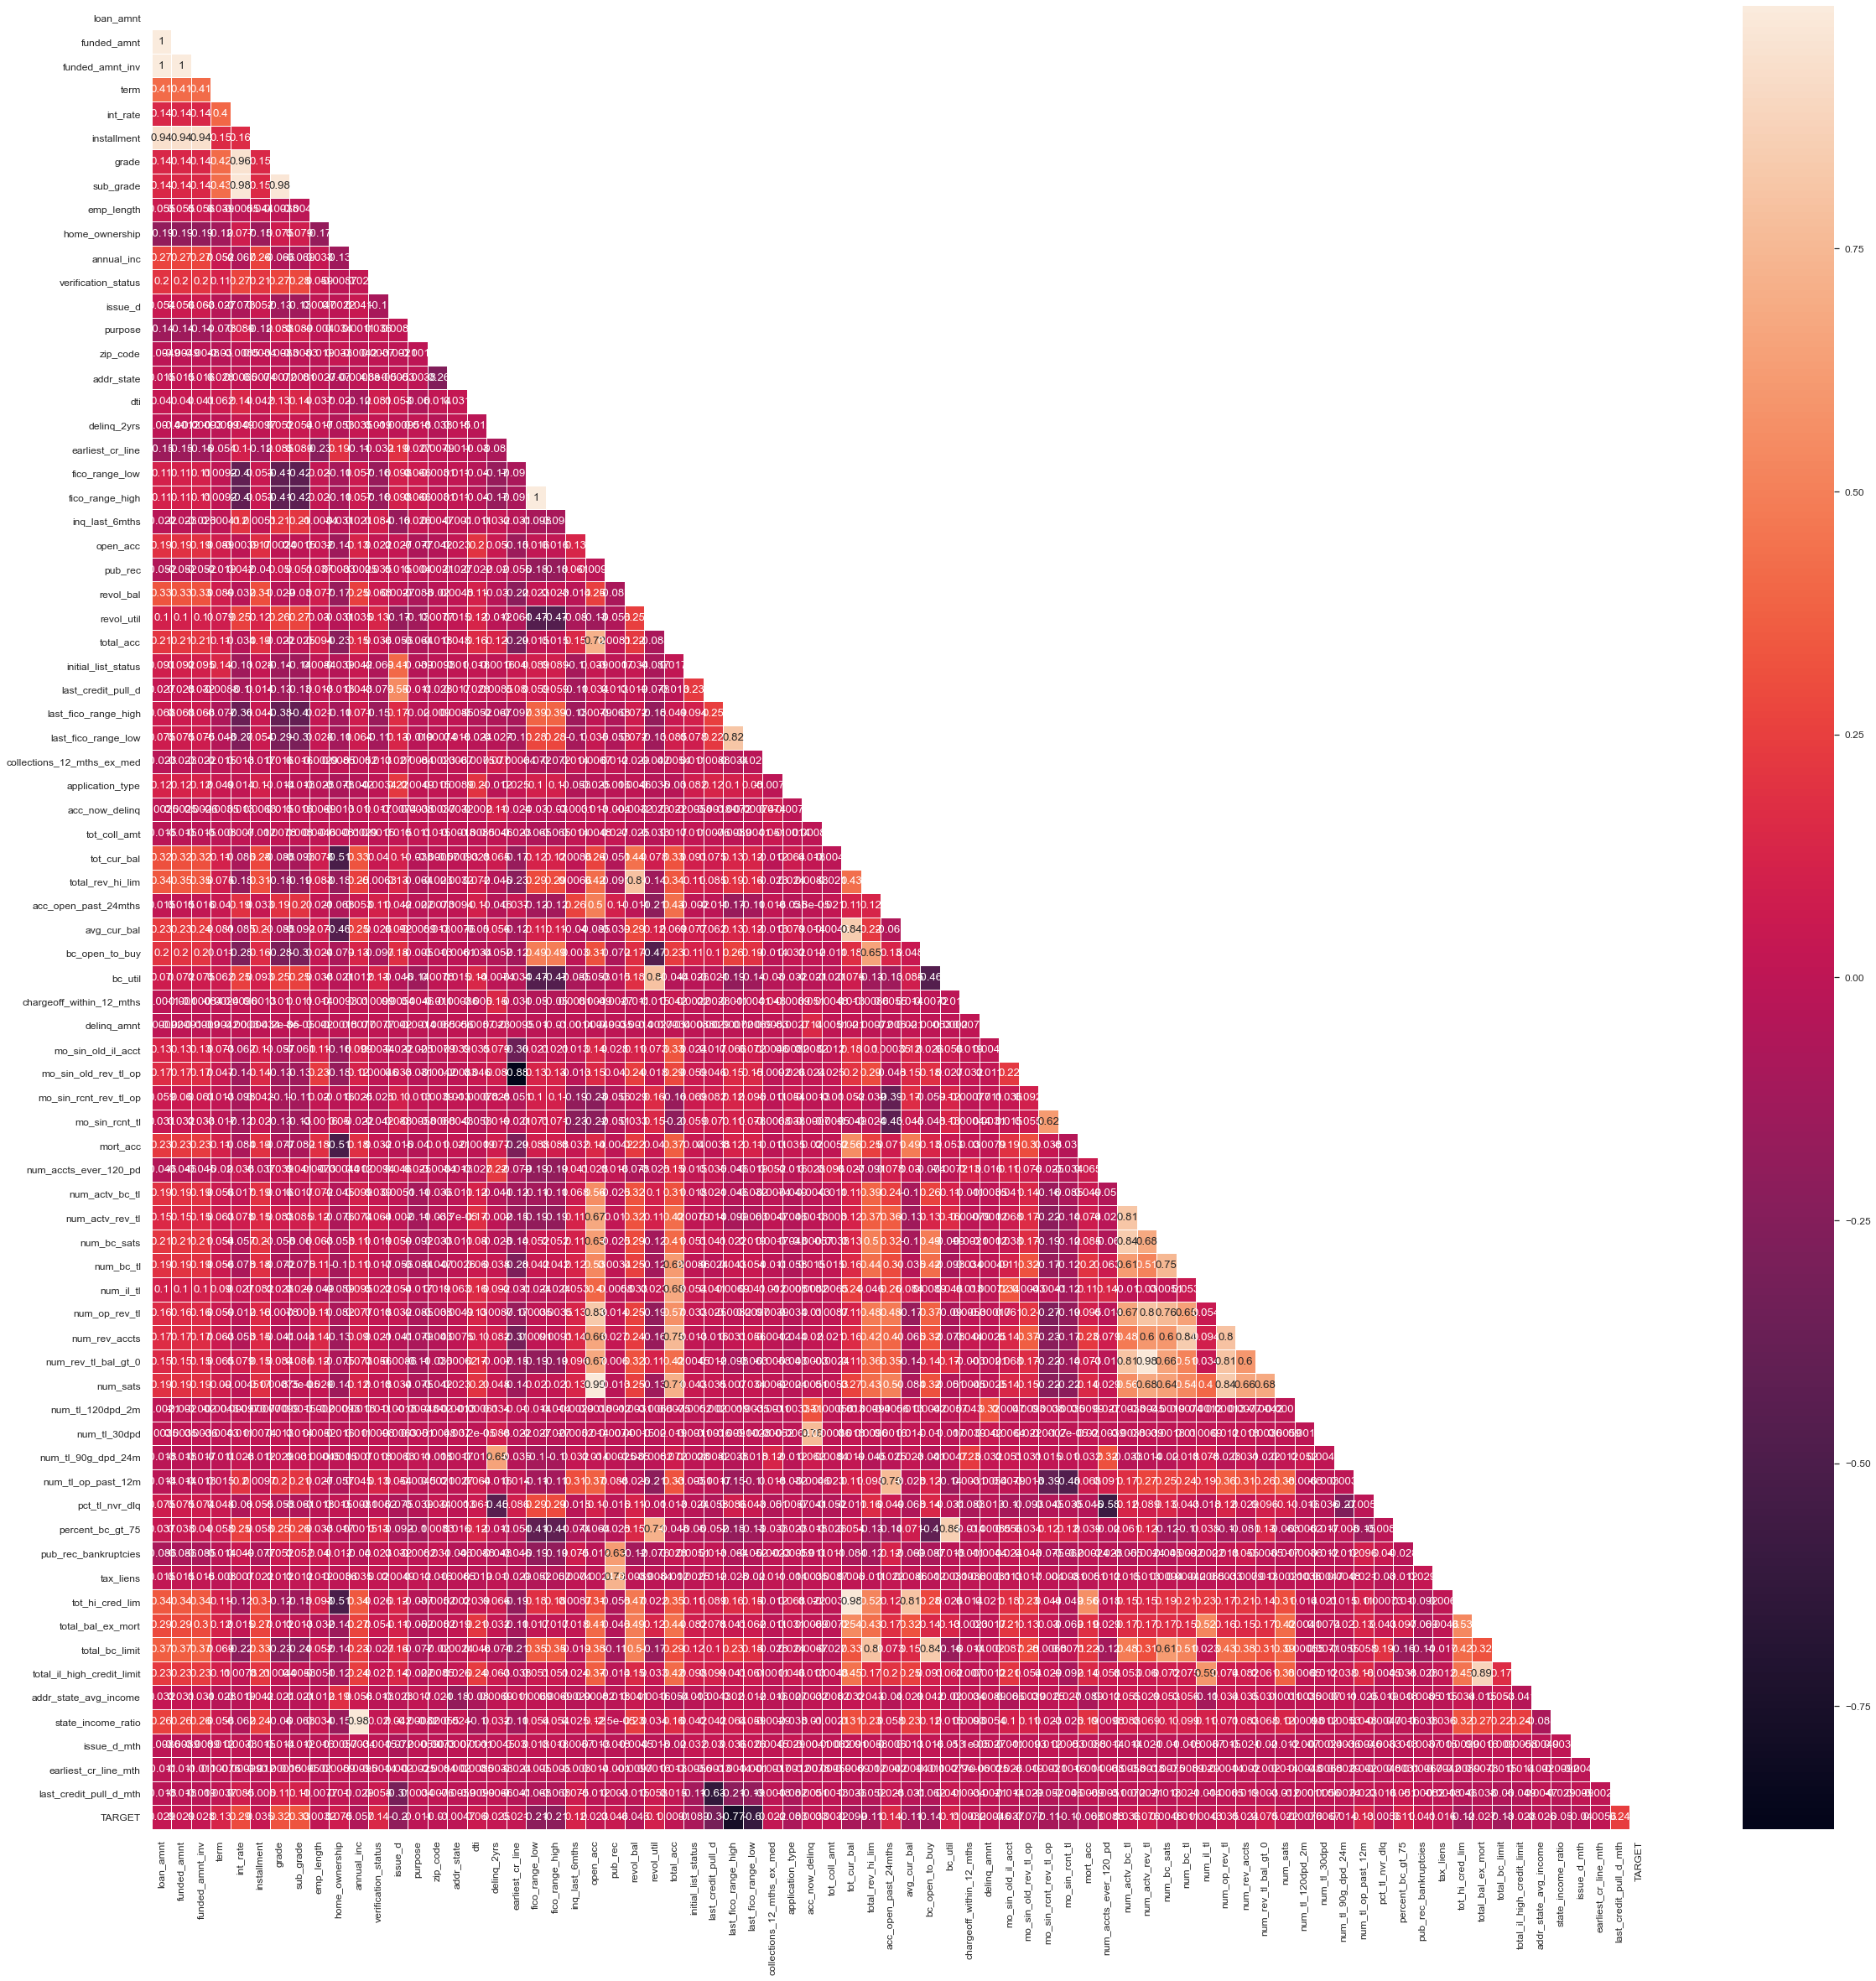

In [ ]:
fig, ax = plt.subplots(figsize=(40, 40))

corr = data_preprocessed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

sns.heatmap(corr, annot=True, linewidths=.5, ax=ax, mask=mask)
plt.show()

As it can be seen in the above there are several features with high correlation. Let's further investigate these.

In [ ]:
# calculate abs correlation to take strong positive and negative correlations into account.
corr_abs = corr.abs()

pairs = corr.unstack()
pairs_ordered = pairs.sort_values(kind="quicksort", ascending=False)

print(pairs_ordered[pairs_ordered < 1.0].head(30))

fico_range_low              fico_range_high               1.000000
fico_range_high             fico_range_low                1.000000
funded_amnt                 loan_amnt                     0.999759
loan_amnt                   funded_amnt                   0.999759
funded_amnt                 funded_amnt_inv               0.999182
funded_amnt_inv             funded_amnt                   0.999182
loan_amnt                   funded_amnt_inv               0.998873
funded_amnt_inv             loan_amnt                     0.998873
open_acc                    num_sats                      0.990650
num_sats                    open_acc                      0.990650
tot_cur_bal                 tot_hi_cred_lim               0.984383
tot_hi_cred_lim             tot_cur_bal                   0.984383
num_actv_rev_tl             num_rev_tl_bal_gt_0           0.983216
num_rev_tl_bal_gt_0         num_actv_rev_tl               0.983216
annual_inc                  state_income_ratio            0.97

We decided to drop columns with a high correlation and keep only one of them. This is similar to the approach in the paper *Credit Risk Analysis in Peer-to-Peer Lending System*.

In [ ]:
data_preprocessed = data_preprocessed.drop(columns=['fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'num_sats'])

## Task 3: Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression. (20 points)

To compare the models in the end a DataFrame to store the performance metrics is created.

In [ ]:
performance = pd.DataFrame()

The model evaluation is conducted with the following methods. For in-sample testing the training and testing is conducted on the same dataset. For the performance evaluation accuracy, precision, recall, f1-score are calculated and the results are visualized. Due to the imbalanced dataset the performance metrics "Balanced Accuracy" and "Matthews Corrcoef" are calculated in addition, since they take the imbalance of the data into consideration.

In [ ]:
# function to print metrics in-sample.

def print_results_in_sample(model, performance):
    y_pred_model = model.predict(X)

    print(classification_report(y, y_pred_model))

    plot_confusion_matrix(model, X, y, display_labels=['Non-Default', 'Default'])
    plt.show()

    print(f"Accuracy: {accuracy_score(y, y_pred_model):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_pred_model):.2f}")
    print(f"Matthews Corrcoef: {matthews_corrcoef(y, y_pred_model):.2f}")
    print(f"Params: {model.get_params()}")

    performance_metrics = pd.DataFrame(
        {'Accuracy': accuracy_score(y, y_pred_model), 'Balanced Accuracy': balanced_accuracy_score(y, y_pred_model),
         'Matthews Corrcoef': matthews_corrcoef(y, y_pred_model)}, [f"{model.__class__.__name__}"])
    performance = performance.append(performance_metrics)
    return performance

In [ ]:
# function print roc curve in-sample.

def print_performance_measures_in_sample(model):

    plt.figure(figsize=(9, 9))
    roc_auc(model, X, y.values.ravel(), X_test=X, y_test=y.values.ravel(), classes=["True", "False"], binary=True)
    plt.show()

              precision    recall  f1-score   support

           0       0.92      0.92      0.92    196549
           1       0.89      0.89      0.89    146439

    accuracy                           0.91    342988
   macro avg       0.90      0.90      0.90    342988
weighted avg       0.91      0.91      0.91    342988



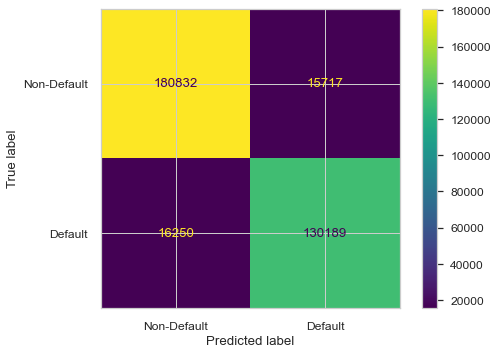

Accuracy: 0.91
Balanced Accuracy: 0.90
Matthews Corrcoef: 0.81
Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


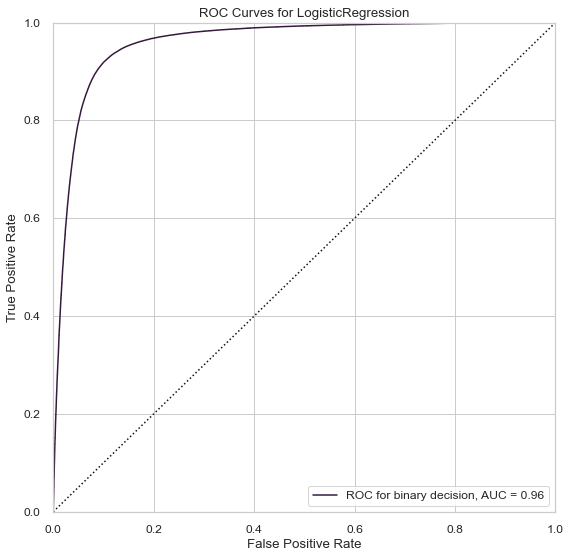

In [ ]:
#Logistic Regression

param_grid = {'penalty': ['l2'], 'tol': [1e-4, 1e-3], 'C': [0.5, 1.0, 2.0], 'solver': ['saga'],
              'max_iter': [250, 500]}

# perform grid search
grid_lg = GridSearchCV(LogisticRegression(), param_grid, n_jobs=-1, verbose=0)  
grid_lg.fit(X, y.values.ravel())

# choose best model
grid_lg_optimized = grid_lg.best_estimator_

# print metrics and confusion matrix
performance = print_results_in_sample(grid_lg_optimized, performance)
print_performance_measures_in_sample(grid_lg_optimized)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression  0.906798           0.904534           0.809447

## Task 4: Compare logistic regression, classification tree, random forest, bagging, support vector machine (with two kernel functions), and neural network for default prediction based on the out-of-sample performance measures (at least three different measures). (35 points)

### Preliminary

For model evaluation the same performance metrics as above are calculated. In contrast to the in-sampling method for Logistic Regression an out-of-sample approach is used by using unseen data for testing.

In [ ]:
# function to print out-of-sample metrics

def print_results(model, performance):
    y_pred_model = model.predict(X_test)

    print(classification_report(y_test, y_pred_model))

    fig, ax = plt.subplots(figsize=(16, 9))
    disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['Non-Default', 'Default'], ax=ax)
    plt.title(f"Confusion matrix for {model.__class__.__name__}")
    disp.ax_.grid(False)
    plt.show()

    print(f"Accuracy: {accuracy_score(y_test, y_pred_model):.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_model):.2f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred_model):.2f}")
    print()
    print(f"Params: {model.get_params()}")

    performance_metrics = pd.DataFrame({'Accuracy': accuracy_score(y_test, y_pred_model),
                                        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_model),
                                        'Matthews Corrcoef': matthews_corrcoef(y_test, y_pred_model)},
                                       index=[f"{model.__class__.__name__}"])
    performance = performance.append(performance_metrics)
    return performance

In [ ]:
# function to print out-of-sample roc curve

def print_performance_measures(model):  
    plt.figure(figsize=(9, 9))
    roc_auc(model, X_train, y_train, X_test=X_test, y_test=y_test, classes=["Default", "Non-Default"], binary=True)
    plt.show()

### Decision Tree

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     58965
           1       0.70      0.74      0.72      8855

    accuracy                           0.93     67820
   macro avg       0.83      0.85      0.84     67820
weighted avg       0.93      0.93      0.93     67820



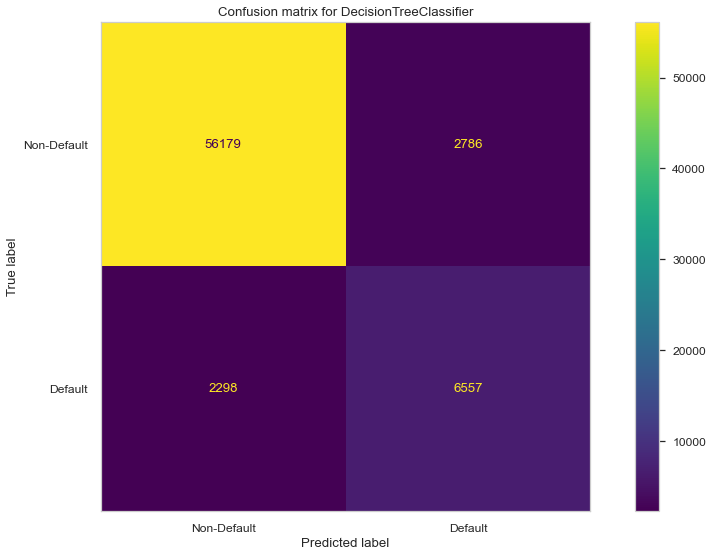

Accuracy: 0.93
Balanced Accuracy: 0.85
MCC: 0.68

Params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


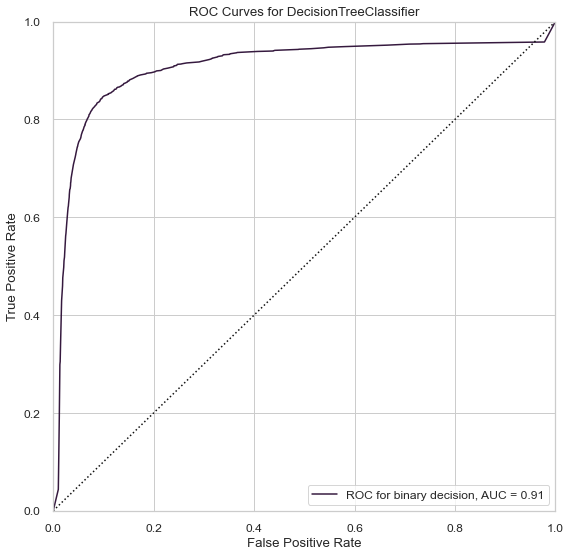

In [ ]:
min_depth = 2
step_size = 4
step_count = 2 ** 4
max_depth = min_depth + np.arange(step_count) * step_size

# perform grid search
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': max_depth}
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_dt.fit(X_train, y_train)

# choose best model
grid_dt_optimized = grid_dt.best_estimator_

# print confusion 
performance = print_results(grid_dt_optimized, performance)

print_performance_measures(grid_dt_optimized)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700

### Plot Decision Tree

To better understand which features are important for the tree, we ploted the first few splits.

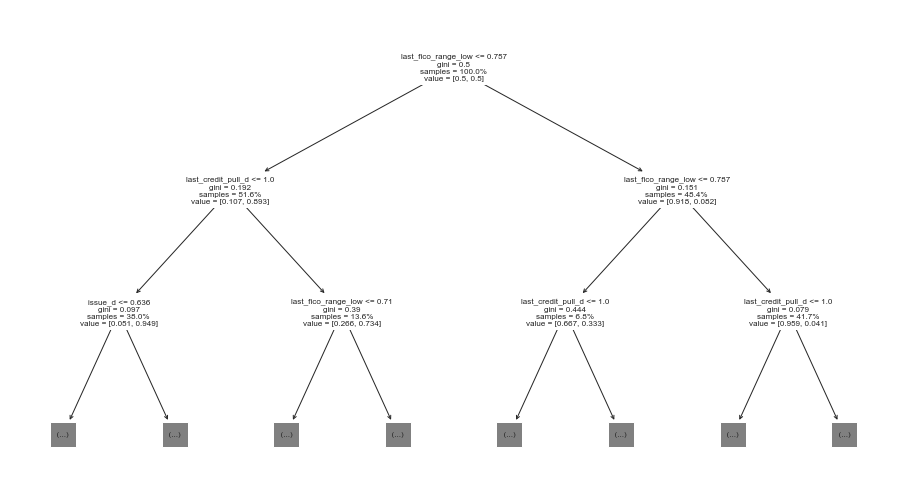

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
tree.plot_tree(grid_dt_optimized, feature_names=X_train.columns, proportion=True, max_depth=2);

### Plot feature importances of Decision Tree

To develop a better understand of what features are important for the tree, we plotted them in a paretto plot. Calculation is done using the Gini ratio. One can see that the feature `last_fico_range_low`, which is similar to the German Schufa score, is of high importance. As it is a measure to assess the creditworthyness of a buyer, it makes sense, that it is useful for default prediction.

In [ ]:
def print_feature_importance(feature_importance, clf):
    """
    function to create a paretto plot with the gini importance of features.
    """
    feature_importance.sort_values(ascending=False, inplace=True, by=0)

    feature_importance['pareto'] = 100 * feature_importance[0].cumsum() / feature_importance[0].sum()
    feature_importance.rename(columns={0: 'importance'}, inplace=True)

    fig, axes = plt.subplots(figsize=(16, 9))
    ax1 = feature_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(0.1))
    ax2 = feature_importance.plot(use_index=True, y='pareto', marker='D', color=cmap(0.7), kind='line', ax=axes,
                                  secondary_y=True)
    ax2.set_ylim([0, 110])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.xticks(rotation=45)
    plt.title(f"feature importances given by '.feature_importances_' for {clf.__class__.__name__}")
    plt.show()

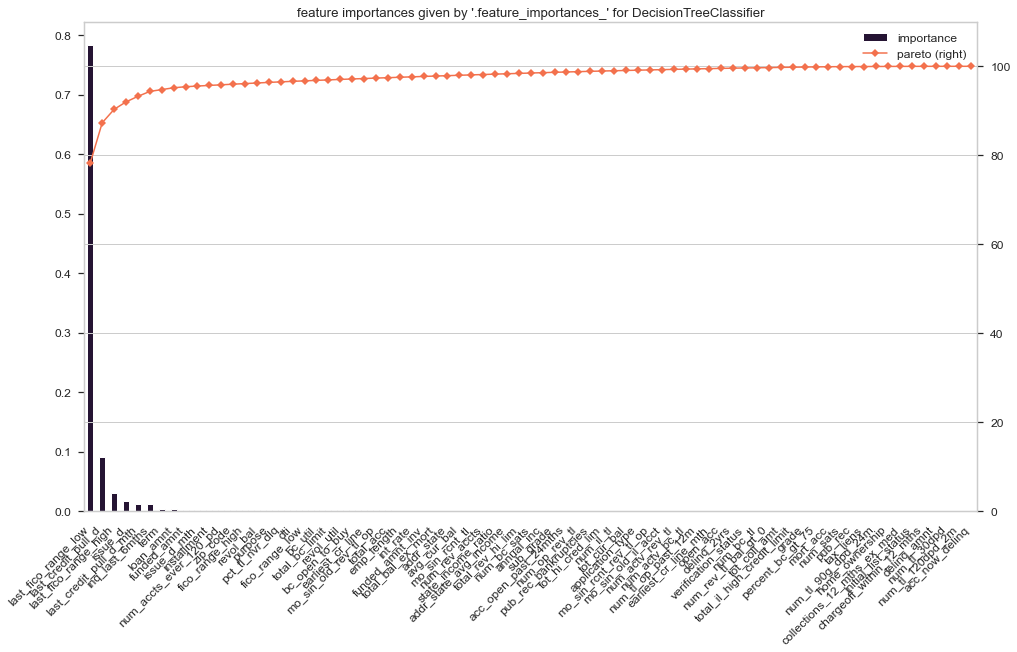

In [ ]:
importance = grid_dt_optimized.feature_importances_
feature_importance = pd.DataFrame(importance, X_train.columns)

print_feature_importance(feature_importance, grid_dt_optimized)

### Random Forest

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     58965
           1       0.67      0.82      0.74      8855

    accuracy                           0.92     67820
   macro avg       0.82      0.88      0.85     67820
weighted avg       0.93      0.92      0.93     67820



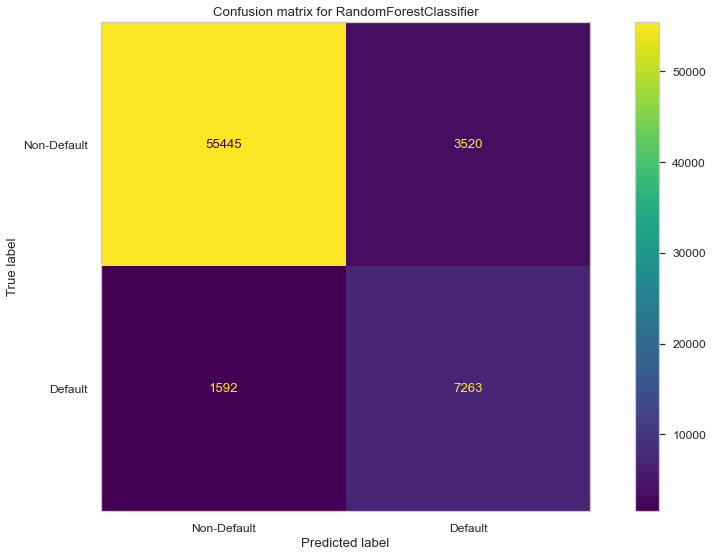

Accuracy: 0.92
Balanced Accuracy: 0.88
MCC: 0.70

Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


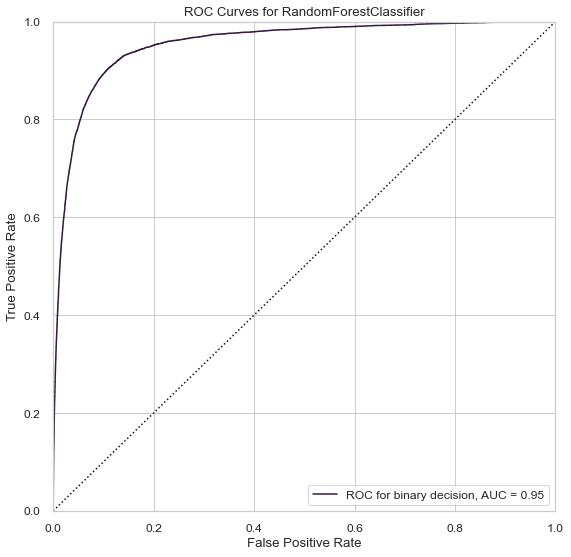

In [ ]:
max_depth = np.arange(6, 22, 4)
n_estimators = [5, 25, 50, 100, 150]

# perform grid search
param_grid = {'criterion': ['entropy'], 'max_depth': max_depth, 'n_estimators': n_estimators}
grid_rf = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_rf.fit(X_train, y_train.values.ravel())

# choose best model
grid_rf_optimized = grid_rf.best_estimator_

# print confusion 
performance = print_results(grid_rf_optimized, performance)

print_performance_measures(grid_rf_optimized)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733

### Bagging

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     58965
           1       0.61      0.85      0.71      8855

    accuracy                           0.91     67820
   macro avg       0.79      0.89      0.83     67820
weighted avg       0.93      0.91      0.92     67820



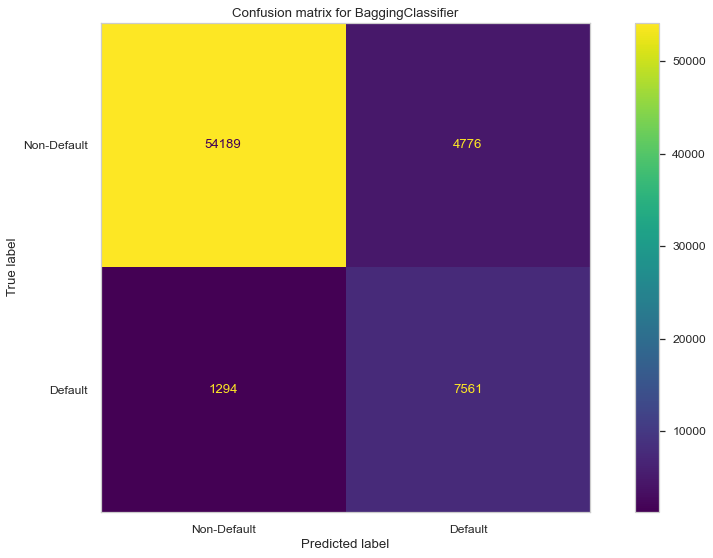

Accuracy: 0.91
Balanced Accuracy: 0.89
MCC: 0.68

Params: {'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 5, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(max_depth=5), 'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.2, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


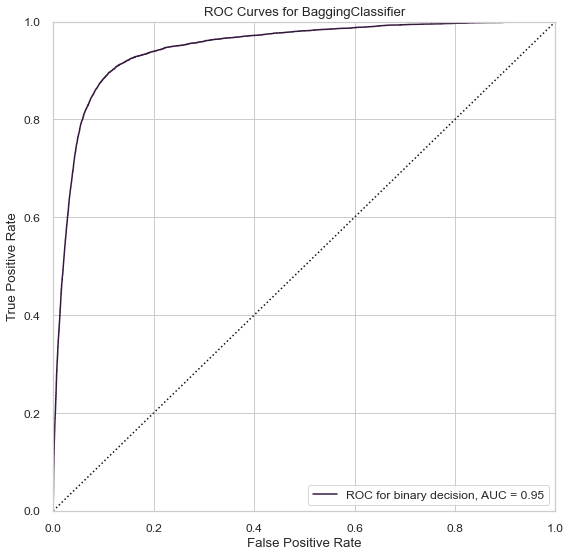

In [ ]:
# perform grid search
param_grid = {
    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]
}

grid_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5, n_jobs=-1),
                   param_grid, n_jobs=-1)
grid_bag.fit(X_train, y_train.values.ravel())

# choose best model
grid_bag_optimized = grid_bag.best_estimator_

# print confusion 
performance = print_results(grid_bag_optimized, performance)
print_performance_measures(grid_bag_optimized)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733
BaggingClassifier       0.910498           0.886435           0.675015

### Support Vector Machine

Next, we look at SVM with two different kernels. Namely, a rfb kernel and linear kernel.

Due to extremely long runtimes (> 5h) we used a much smaller grid for the SVM. We fixed the $C$ and set an upper limit for the number of iterations. 

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     58965
           1       0.58      0.88      0.70      8855

    accuracy                           0.90     67820
   macro avg       0.78      0.89      0.82     67820
weighted avg       0.93      0.90      0.91     67820



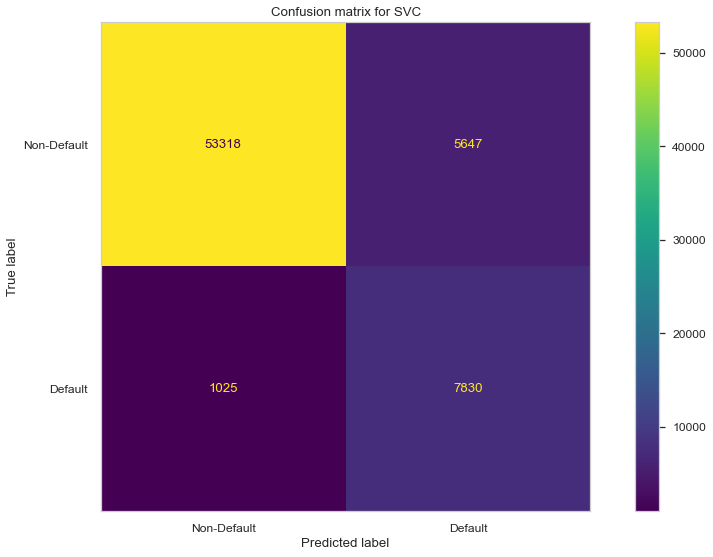

Accuracy: 0.90
Balanced Accuracy: 0.89
MCC: 0.67

Params: {'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 100000, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


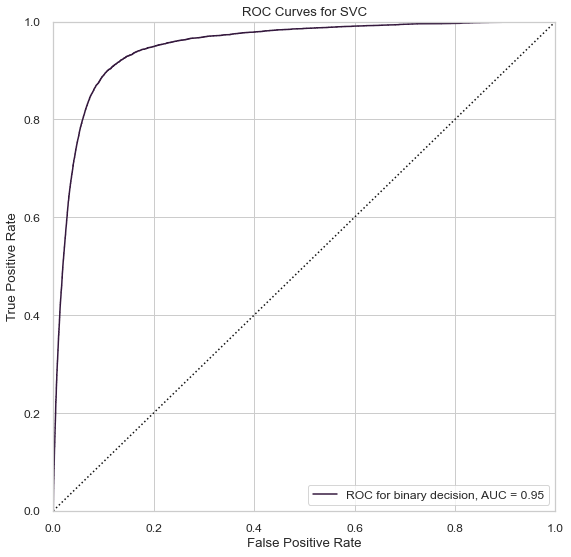

In [ ]:
# perform grid search
param_grid = {'C': [0.1], 'kernel': ['linear','sigmoid'], 'max_iter':[100000]}
grid_svm = GridSearchCV(SVC(), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_svm.fit(X_train, y_train.values.ravel())

# choose best model
grid_svm_optimized = grid_svm.best_estimator_

# print confusion 
performance = print_results(grid_svm_optimized, performance)

print_performance_measures(grid_svm_optimized)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733
BaggingClassifier       0.910498           0.886435           0.675015
SVC                     0.901622           0.894239           0.665752

### Neural Network 

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     58965
           1       0.57      0.89      0.69      8855

    accuracy                           0.90     67820
   macro avg       0.78      0.89      0.82     67820
weighted avg       0.93      0.90      0.91     67820



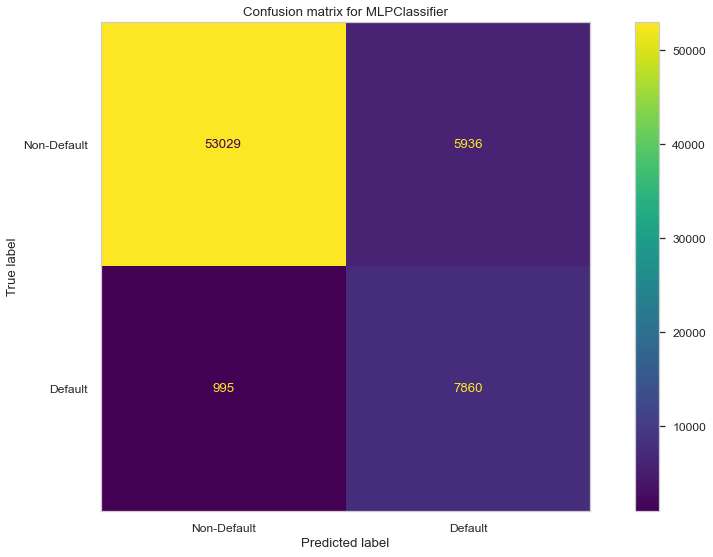

Accuracy: 0.90
Balanced Accuracy: 0.89
MCC: 0.66

Params: {'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 2), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


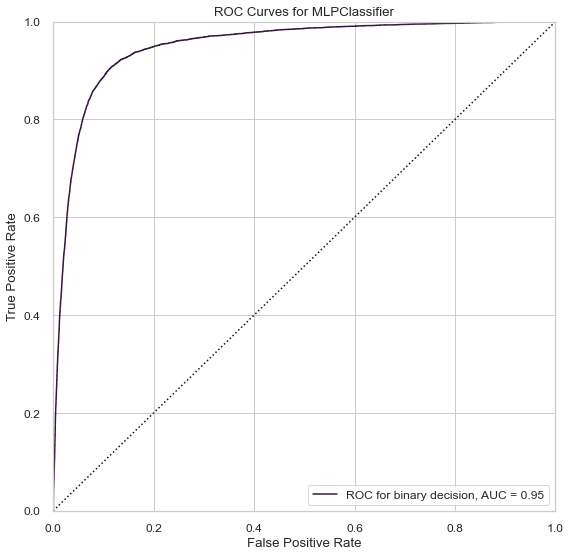

In [ ]:
# perform grid search
param_grid = {'activation': ['logistic', 'relu'],
              'hidden_layer_sizes': [(100, 1), (100, 2)], 'early_stopping': [True]}
grid_nn = GridSearchCV(MLPClassifier(), param_grid, refit=True, verbose=0, n_jobs=-1)
grid_nn.fit(X_train, y_train.values.ravel())

# choose best model
grid_nn_optimized = grid_nn.best_estimator_

# print confusion 
performance = print_results(grid_nn_optimized, performance)
print_performance_measures(grid_nn_optimized)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733
BaggingClassifier       0.910498           0.886435           0.675015
SVC                     0.901622           0.894239           0.665752
MLPClassifier           0.897803           0.893482           0.658683

### Boosting Approach

As described above, we added an additional Boosting approach to campare its results to the necessary models.

0:	learn: 0.5439940	test: 0.5439940	test1: 0.5588042	best: 0.5588042 (0)	total: 6.09s	remaining: 10m 3s
1:	learn: 0.4224374	test: 0.4224374	test1: 0.4582759	best: 0.4582759 (1)	total: 12.3s	remaining: 10m 1s
2:	learn: 0.3448570	test: 0.3448570	test1: 0.3890817	best: 0.3890817 (2)	total: 18.1s	remaining: 9m 43s
3:	learn: 0.2881290	test: 0.2881290	test1: 0.3370835	best: 0.3370835 (3)	total: 23.5s	remaining: 9m 23s
4:	learn: 0.2492476	test: 0.2492476	test1: 0.3019201	best: 0.3019201 (4)	total: 29.1s	remaining: 9m 13s
5:	learn: 0.2176237	test: 0.2176237	test1: 0.2724582	best: 0.2724582 (5)	total: 34.7s	remaining: 9m 3s
6:	learn: 0.1980206	test: 0.1980206	test1: 0.2550483	best: 0.2550483 (6)	total: 40.1s	remaining: 8m 53s
7:	learn: 0.1822197	test: 0.1822197	test1: 0.2402005	best: 0.2402005 (7)	total: 45.7s	remaining: 8m 45s
8:	learn: 0.1671813	test: 0.1671813	test1: 0.2269978	best: 0.2269978 (8)	total: 51.2s	remaining: 8m 37s
9:	learn: 0.1569493	test: 0.1569493	test1: 0.2170445	best: 0.2170

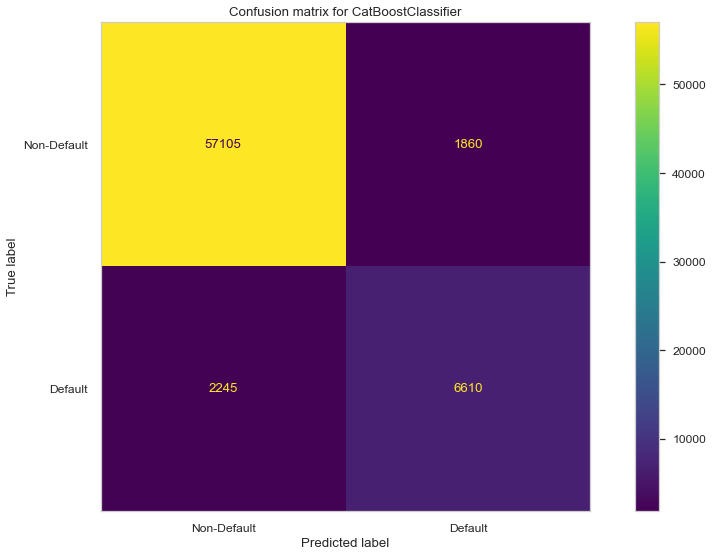

Accuracy: 0.94
Balanced Accuracy: 0.86
MCC: 0.73

Params: {'iterations': 100, 'learning_rate': 0.1, 'depth': 14}


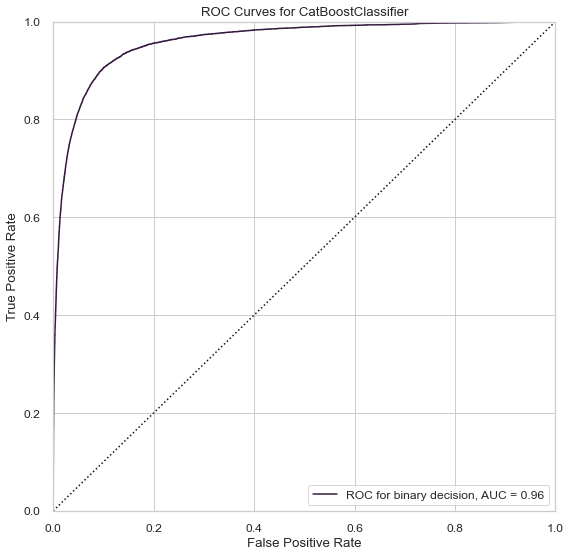

In [ ]:

clf_cat = CatBoostClassifier(iterations=100)
parameters = {'learning_rate': [0.03, 0.1, 0.3] ,'depth': [14]}

# perform grid search
grid_cat = GridSearchCV(clf_cat,
                    parameters, n_jobs=-1,
                    scoring="neg_log_loss",
                    cv=3)


eval_set = [(X_train, y_train), (X_test, y_test)]
grid_cat.fit(X_train, y_train, eval_set=eval_set) 

grid_cat_optimized = grid_cat.best_estimator_

performance = print_results(grid_cat_optimized, performance)
print_performance_measures(classifier(grid_cat_optimized))

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733
BaggingClassifier       0.910498           0.886435           0.675015
SVC                     0.901622           0.894239           0.665752
MLPClassifier           0.897803           0.893482           0.658683
CatBoostClassifier      0.939472           0.857463           0.728620

To better understand the results of the Boosting approach. We compare the logloss of the testing and the training set. One can see, that there is a slight overfit. As the logloss decreases for a larger number of trees, but the logloss remains almost constant after about 40 iterations for the test set. Overall though, the results of the Boosting approach are very promising. 

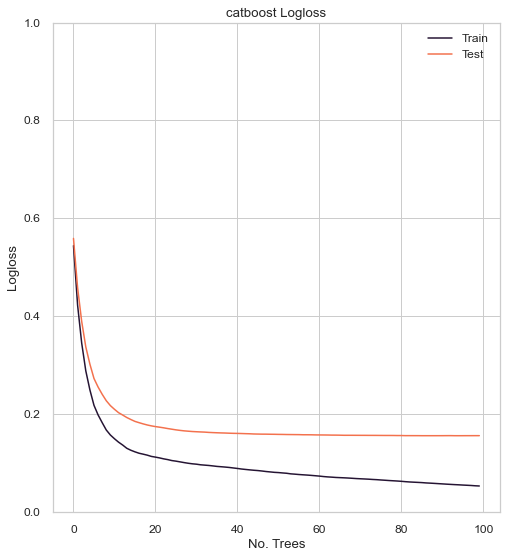

In [ ]:
# create lineplot showing improvement lof logloss
results = grid_cat_optimized.evals_result_
epochs = len(results['validation_0']['Logloss'])
x_axis = range(0, epochs)
plt.figure(figsize=(8,9))
sns.lineplot(x=x_axis, y=results['validation_0']['Logloss'], label='Train', color=cmap(0.1))
sns.lineplot(x=x_axis, y=results['validation_1']['Logloss'], label='Test', color=cmap(0.7))
plt.legend()
plt.ylim((0,1))
plt.ylabel('Logloss')
plt.title('catboost Logloss')
plt.xlabel('No. Trees')
plt.show()

### Feature Importances Boosting approach

As for the decision tree, we also investigated the feature importances for the Boosting approach. The used features are very different from the ones used in the decision trees. Also far more features are incorporated in the final prediction.

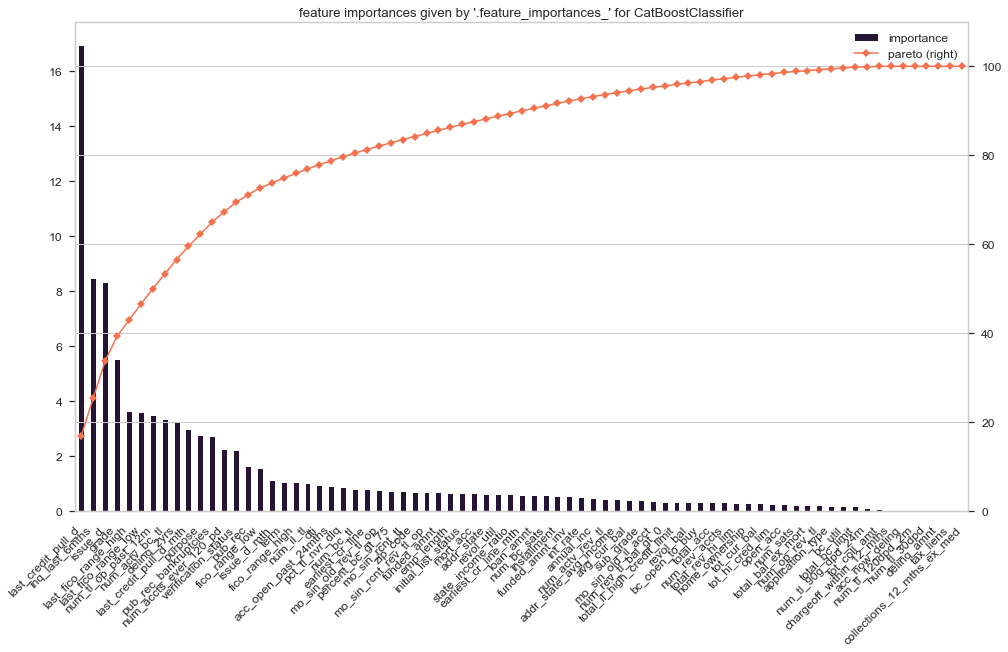

In [ ]:
importance = grid_cat_optimized.feature_importances_
feature_importance = pd.DataFrame(importance, X_train.columns)
print_feature_importance(feature_importance, grid_cat_optimized)

To further improve the performance we tried Ensemble models. The best out-of-sample classifiers are combined using a Voting Classifier. Our Voting Classifier uses the Majority Vote of two classifiers. the Stacking Classifier "stacks" the two models behind each other. We also build a Stacking Classifier from the Neural Net and the Random Forest to see if we could boost performance even further.

## Voting Classifier

0:	learn: 0.5439940	total: 5.44s	remaining: 8m 58s
1:	learn: 0.4224374	total: 10.5s	remaining: 8m 36s
2:	learn: 0.3448570	total: 15.5s	remaining: 8m 22s
3:	learn: 0.2881290	total: 20.5s	remaining: 8m 12s
4:	learn: 0.2492476	total: 25.6s	remaining: 8m 7s
5:	learn: 0.2176237	total: 30.7s	remaining: 8m
6:	learn: 0.1980206	total: 35.9s	remaining: 7m 56s
7:	learn: 0.1822197	total: 40.8s	remaining: 7m 49s
8:	learn: 0.1671813	total: 45.6s	remaining: 7m 41s
9:	learn: 0.1569493	total: 50.6s	remaining: 7m 35s
10:	learn: 0.1492911	total: 55.6s	remaining: 7m 29s
11:	learn: 0.1422862	total: 1m	remaining: 7m 23s
12:	learn: 0.1364500	total: 1m 5s	remaining: 7m 18s
13:	learn: 0.1298223	total: 1m 10s	remaining: 7m 13s
14:	learn: 0.1257773	total: 1m 15s	remaining: 7m 8s
15:	learn: 0.1225306	total: 1m 20s	remaining: 7m 3s
16:	learn: 0.1196890	total: 1m 25s	remaining: 6m 58s
17:	learn: 0.1178028	total: 1m 30s	remaining: 6m 52s
18:	learn: 0.1157735	total: 1m 35s	remaining: 6m 48s
19:	learn: 0.1132009	total

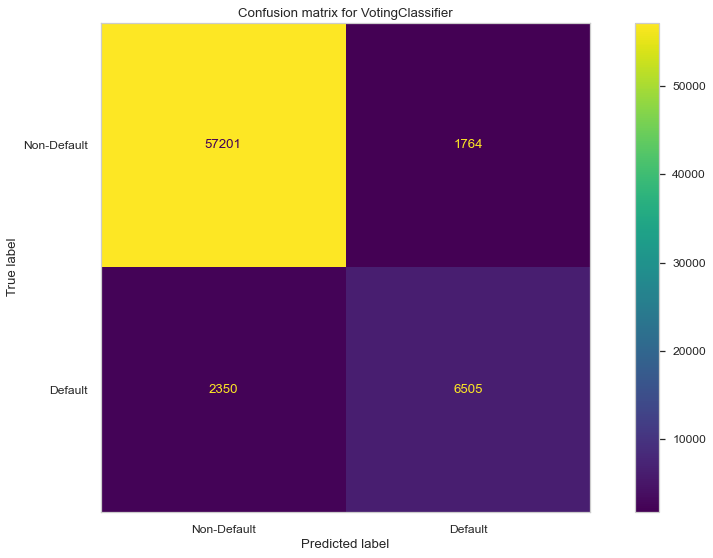

Accuracy: 0.94
Balanced Accuracy: 0.85
MCC: 0.73

Params: {'estimators': [('Cat Boost', <catboost.core.CatBoostClassifier object at 0x00000231AE788220>), ('Random Forest', RandomForestClassifier(criterion='entropy', max_depth=18, n_jobs=-1))], 'flatten_transform': True, 'n_jobs': None, 'verbose': False, 'voting': 'hard', 'weights': None, 'Cat Boost': <catboost.core.CatBoostClassifier object at 0x00000231AE788220>, 'Random Forest': RandomForestClassifier(criterion='entropy', max_depth=18, n_jobs=-1), 'Cat Boost__iterations': 100, 'Cat Boost__learning_rate': 0.1, 'Cat Boost__depth': 14, 'Random Forest__bootstrap': True, 'Random Forest__ccp_alpha': 0.0, 'Random Forest__class_weight': None, 'Random Forest__criterion': 'entropy', 'Random Forest__max_depth': 18, 'Random Forest__max_features': 'auto', 'Random Forest__max_leaf_nodes': None, 'Random Forest__max_samples': None, 'Random Forest__min_impurity_decrease': 0.0, 'Random Forest__min_impurity_split': None, 'Random Forest__min_samples_lea

In [ ]:
model_voting = VotingClassifier(estimators=[('Cat Boost', grid_cat_optimized), ('Random Forest', grid_rf_optimized)],
                                   voting='hard')
model_voting.fit(X_train, y_train.values.ravel())

performance = print_results(model_voting, performance)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733
BaggingClassifier       0.910498           0.886435           0.675015
SVC                     0.901622           0.894239           0.665752
MLPClassifier           0.897803           0.893482           0.658683
CatBoostClassifier      0.939472           0.857463           0.728620
VotingClassifier        0.939339           0.852349           0.725643

## Stacking Classifier

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     58965
           1       0.67      0.82      0.74      8855

    accuracy                           0.92     67820
   macro avg       0.82      0.88      0.85     67820
weighted avg       0.93      0.92      0.93     67820



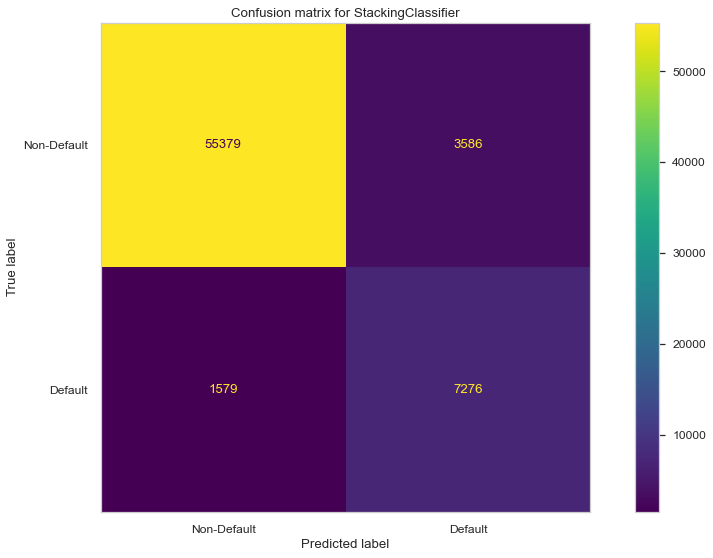

Accuracy: 0.92
Balanced Accuracy: 0.88
MCC: 0.70

Params: {'cv': None, 'estimators': [('Neural Net', MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(100, 2))), ('Random Forest', RandomForestClassifier(criterion='entropy', max_depth=18, n_jobs=-1))], 'final_estimator__C': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 200, 'final_estimator__multi_class': 'auto', 'final_estimator__n_jobs': None, 'final_estimator__penalty': 'l1', 'final_estimator__random_state': None, 'final_estimator__solver': 'liblinear', 'final_estimator__tol': 0.0001, 'final_estimator__verbose': 0, 'final_estimator__warm_start': False, 'final_estimator': LogisticRegression(max_iter=200, penalty='l1', solver='liblinear'), 'n_jobs': None, 'passthrough': False, 'stack_method': 'auto', 'verbose': 0, 'Neural 

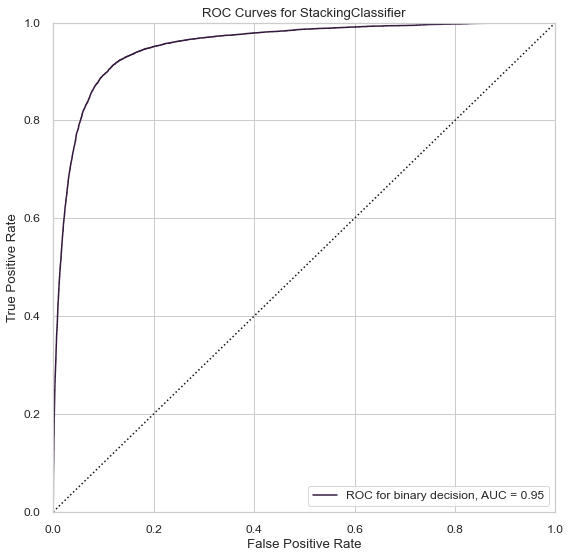

In [ ]:
estimators = [('Neural Net', grid_nn_optimized), ('Random Forest', grid_rf_optimized)]
model_stacked = StackingClassifier(estimators=estimators,
                                   final_estimator=LogisticRegression(max_iter=200, penalty='l1', solver='liblinear'))

model_stacked.fit(X_train, y_train.values.ravel())

performance = print_results(model_stacked, performance)

print_performance_measures(model_stacked)

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733
BaggingClassifier       0.910498           0.886435           0.675015
SVC                     0.901622           0.894239           0.665752
MLPClassifier           0.897803           0.893482           0.658683
CatBoostClassifier      0.939472           0.857463           0.728620
VotingClassifier        0.939339           0.852349           0.725643
StackingClassifier      0.923843           0.880433           0.698985

One can clearly see, that the Accuracy and the MCC is highest for both the **CatBoostClassifer** and the **Voting Classifier**. Considering only the models that were given, the standard **Decision Tree** gives the best Accuracy.

As the data set is imbalanced, looking at the accuracy alone, can be missleading. Therefore one should put more focus on the MCC, which can handle imbalanced data and is standardized to a range of $[-1,1]$. Taking this into account the MCC is good for all models, as it is "fairly" close to $1$. Of all-out-of-sample models, MCC is best for the **CatBoostClassifier** and best for **RandomForestClassifier**, considering only the models given.

For reference, we also printed the Balanced Accuracy, which is pretty similar for all models. 

The results from above are discussed more in-depth in Task 6.

**Note:**
The performance of Logistic Regression can't be compared to the other models, because it was tested in-sample. This means, the model was tested on the same data, it was trained with. Therefore, the calculated performance is likely to be higher than the performance on new, unseen data would be.

## Task 5: Use LASSO for variable selection and explain results. (15 points)

In Task 5 we use a LASSO model for variable selection. First we run a grid search to find a suitable value for the penalty weight $\alpha$. We use the metric Area under the curve (AUC) is the criteria for model selection.

In [ ]:
lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X)
print('X shape: ', X_new.shape)
print('lasso_coef: ', lasso.coef_)
print('lasso_intercept: ', lasso.intercept_)
print('lasso_alpha: ', lasso.alpha_)
lasso_alpha = lasso.alpha_

C:\Users\Markus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


X shape:  (342988, 45)
lasso_coef:  [-0.00000000e+00 -3.53323274e-02 -6.74392936e-02  6.11680830e-02
 -3.43878876e-01  3.06824492e-01  4.97169880e-02  3.32612727e-01
  1.26858304e-02  1.17361407e-02 -3.70271743e-02  1.24148227e-02
 -1.90780920e-02 -7.37834750e-02 -8.47253677e-03 -4.23152258e-03
  2.87216920e-01 -4.94815748e-02 -3.68514865e-02  2.94857483e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.39317161e-03 -1.21101422e-01  5.47850897e-02 -3.90694069e-03
 -5.31474352e-01 -4.17787903e+00  2.56372167e-01  0.00000000e+00
 -4.96995251e-03 -0.00000000e+00  0.00000000e+00 -4.54826742e-01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.27727496e-01
  8.06333406e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.14708750e-02  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  4.78381771e-02 -5.61228801e-02 -0.00000000e+00 -2.22824877e-02
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.41563222e-01
 -1.18317089e-01 -0.00000000e+00 -0.00000000e+00  0.00

Next we look at coefficient of the optimized alpha and plot them ordered by their *absolute* weight.

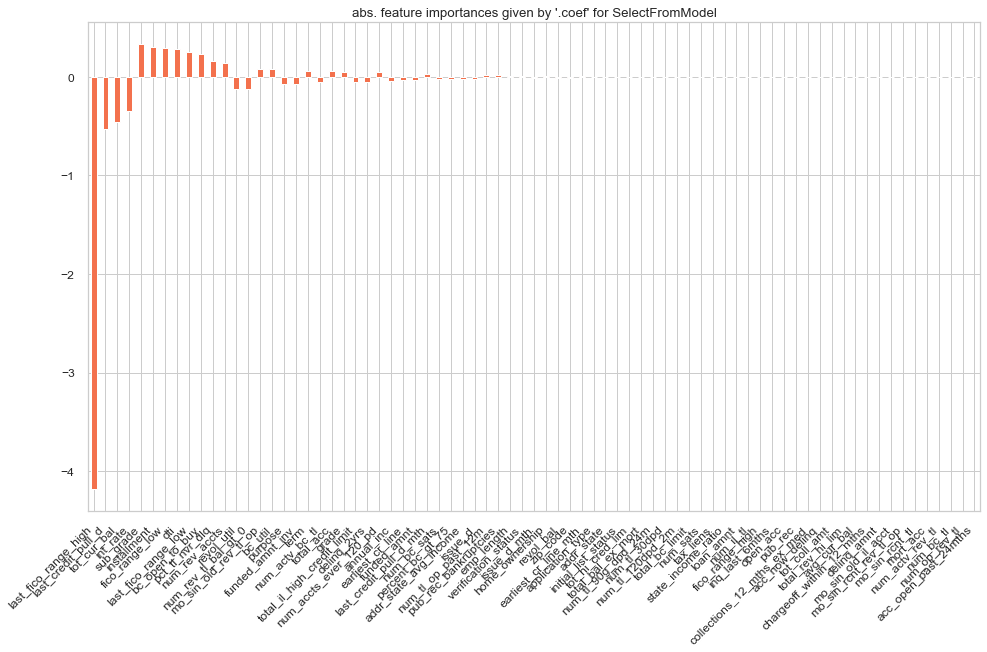

In [ ]:
# get feature importances from the model
coef_importance = pd.DataFrame(lasso.coef_, index=X.columns)
coef_importance.rename(columns={0: 'importance'}, inplace=True)
coef_importance = coef_importance.iloc[(-np.abs(coef_importance['importance'].values)).argsort()]

fig, axes = plt.subplots(figsize=(16, 9))
ax1 = coef_importance.plot(use_index=True, y='importance', kind='bar', ax=axes, color=cmap(0.7), legend=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.xticks(rotation=45)
plt.title(f"abs. feature importances given by '.coef' for {model.__class__.__name__}")
plt.show()

As one can see above, only a very small subset of features would be selected. Of all $75$ features, one would zero-out $30$ features and keep the remaining $35$ features. The selected variables can be also seen from the plot above. These are `last_fico_range_high` until `emp_length`.

To get a better understand of how varying the $\alpha$ the choice of variables and the impact on the coefficients, we decided to plot the LASSO paths. This can be seen in the next plot.

In [ ]:
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, n_alphas=20, fit_intercept=False)

C:\Users\Markus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.354819994521677, tolerance: 14.6439
  model = cd_fast.enet_coordinate_descent_multi_task(


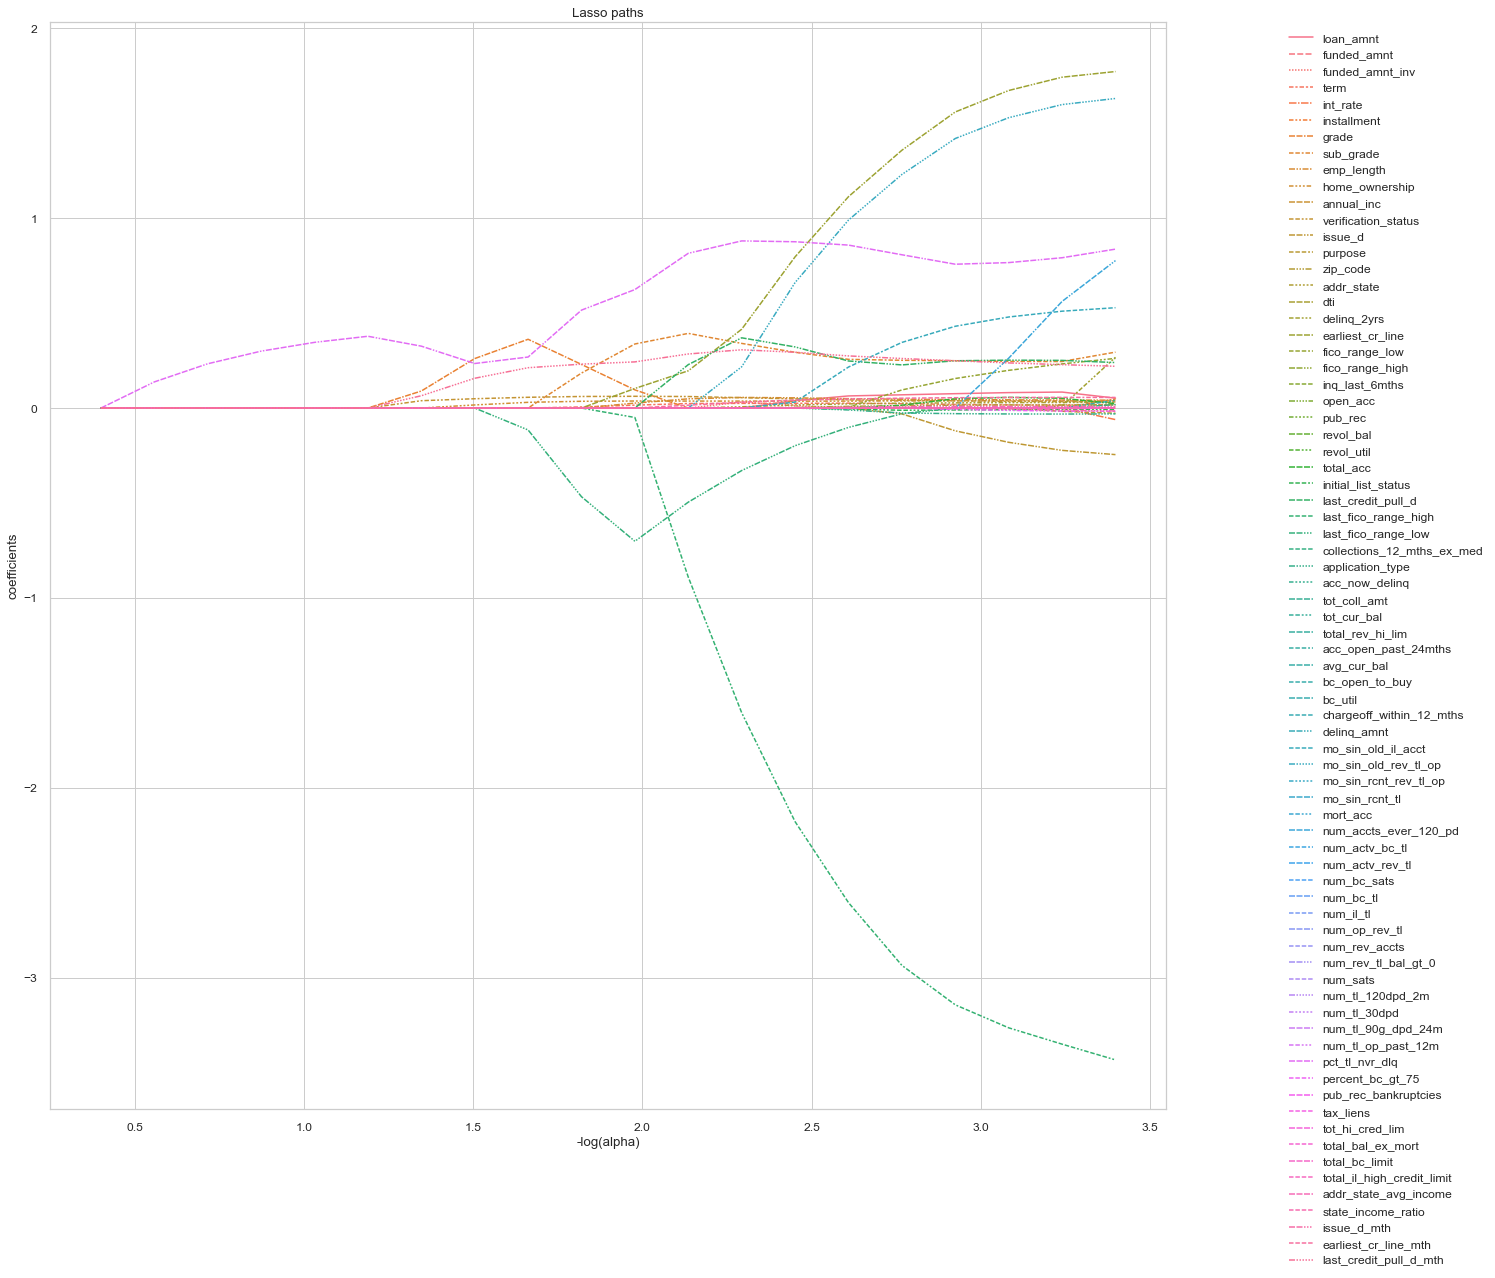

In [ ]:
neg_log_alphas_lasso = -np.log10(alphas_lasso)

# create df with coefs and their importance
df_test = pd.DataFrame(coefs_lasso[0], index=X.columns)
df_test.columns = neg_log_alphas_lasso

# plot
plt.figure(figsize=(20, 20))
g = sns.lineplot(data=df_test.T)
plt.xlabel('-log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso paths')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show(g);

## Task 6: Which model do you suggest to the peer-to-peer company? Why? (10 points)

In addition to performance-based measures, classifiers can be compared from following aspects:
*   Speed
*   Interpretability 
*   Robustness
*   Scalability

### Performance

In [ ]:
performance

Accuracy  Balanced Accuracy  Matthews Corrcoef
LogisticRegression      0.906798           0.904534           0.809447
DecisionTreeClassifier  0.925037           0.846619           0.677700
RandomForestClassifier  0.924624           0.880259           0.700733
BaggingClassifier       0.910498           0.886435           0.675015
SVC                     0.901622           0.894239           0.665752
MLPClassifier           0.897803           0.893482           0.658683
CatBoostClassifier      0.939472           0.857463           0.728620
VotingClassifier        0.939339           0.852349           0.725643
StackingClassifier      0.923843           0.880433           0.698985

describe which model has best performance, e.g. voting/ stacking classifiers?
describe which performance measure is good? e.g. one of the ones which take imbalanced data into consideration?

###Interpretability
For model acceptance the interpretability of the model is of high relevance. The prediction results of a Logistic Regression and the Decision Tree are in contrast to the other models understandable and interpretable. Regarding this factor these two models should be preferred.

###Robustness
(This refers to the ability of the classifiers to classifying noisy data or data with missing values.)
Welches Modell ist hier gut?
SVM, Neuronale Netze und Decision Trees neigen zum Overfitting, die dann eher nicht oder? 

###Scalability
(This is the ability of the classifier to work with large amount of data.)
Neuronale Netze sind bei großen Datenmengen doch normalerweise geeignet oder?

### Computational effort
The computational effort of the SVM, the Random Forest and the Neural Network is high in comparison to Decision Tree, Bagging and Logistic Regression.

In [ ]:
# TODO: Not yet implemented...
# Discussion Voting Classifier -> include short discussion of weaknesses and strengths of models and weaknesses
# Plot Treefunction DT Path tree.plot_tree(clf) 

# Criteria from slide


# Discussion why accuracy is a good criteria (balanced data)

# TODO: consider cost function. Loans that can not repaid are more expensive than loans, that are not handed out.